# Implementation of Tabular Reinforcement Learning Method on Windy Grid World Problem 

|No|Name|Student id|
|:-:|:-:|:-:|
|1.|Lim Yi Jing|AIT2104245|
|2.|Chiam Yu Wei|AIT2104240|
|3.|Cheng Hung Xu|EEE2004045|
|4.|Lee Jean Sean|AIT2104012|

### Introduction

Reinforcement Learning (RL) offers powerful tools for training agents in dynamic environments. This study focuses on two grid-world environments: the deterministic Windy Grid World and its stochastic counterpart. Our aim is to compare the performance of **RL algorithms—Dynamic Programming, Monte Carlo, TD Learning, and Monte Carlo Tree Search**, across these environments, shedding light on their adaptability and generalization in both deterministic and stochastic settings.<br>

#### Problem Formulation

**1. Generalization**

- How well do the RL algorithms generalize their learned policies from the deterministic environment to the stochastic counterpart, and vice versa?
- Are there algorithmic tendencies that showcase superior generalization across both deterministic and stochastic settings?

**2. Tabular RL Algorithm Performance**

- What are the comparative performances of Dynamic Programming, Monte Carlo, and TD Learning in terms of convergence speed, efficiency, and robustness within each environment?
- Do certain algorithms demonstrate consistent superiority, or do their performances vary significantly depending on the environmental characteristics?

#### Evaluation Metrics

**1. Convergence Speed**
- The number of episodes or iterations need for the algorithm to converge towards optimal policies.

**2. Policy Effciency**
- The effectiveness of the learned policies in guiding the agent to the goal state in each environment.

**3. Total Reward**
- A metric to quantify the ability of RL algorithm to guide the agent reaches the goal state in least number of steps.

In [1]:
from __future__ import print_function
import numpy as np
import random
import gym
from gym import spaces
import sys
import time
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import random
from copy import deepcopy
import math

### Environment

We have two environments to run for all methods, which are **Windy Grid World with King's Move** and **Stochastic Windy Grid World with King's Move**.

<br>**Windy Grid World King's Move**

The Windy GridWorld with King's Moves is a classic grid-based reinforcement learning environment designed to test the adaptability of agents in the presence of deterministic wind forces. In this scenario, an agent navigates a grid with specified wind strengths in each column, utilizing eight possible moves: North (N), Northeast (NE), East (E), Southeast (SE), South (S), Southwest (SW), West (W), and Northwest (NW). The goal is for the agent to reach a designated goal state while encountering a reward of -1 at every step, except for the goal state, which carries a reward of 0.<br><br>

>Key Features:

* Grid Dimensions: GRID_HEIGHT=7, GRID_WIDTH=10.<br>
* Wind Dynamics: Varying wind strengths in each column, influencing agent movement.<br>
* Start and Goal States: START STATE: (3,0), GOAL STATE: (3,7)<br>
* Visualization: Provides a visual representation of optimal paths using a Q-table.<br>

In [2]:
# function to make sure agent stays inside the environment
def clamp(n, minn, maxn):
    if n < minn:
        return minn
    elif n > maxn:
        return maxn
    else:
        return n

In [51]:
class WindyGridWorldEnvKingsMove(gym.Env):
    '''Creates the Windy GridWorld Environment with King's moves'''
    def __init__(self, GRID_HEIGHT=7, GRID_WIDTH=10, WIND=[0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
                 START_STATE=(3, 0), GOAL_STATE=(3, 7), REWARD=-1):
        self.grid_height = GRID_HEIGHT
        self.grid_width = GRID_WIDTH
        self.wind = WIND
        self.start_state = START_STATE
        self.goal_state = GOAL_STATE
        self.reward = REWARD
        self.action_space = spaces.Discrete(8)  # 8 possible moves
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_height),
            spaces.Discrete(self.grid_width)))
        self.actions = {
            'N': 0, 'NE': 1, 'E': 2, 'SE': 3, 'S': 4, 'SW': 5, 'W': 6, 'NW': 7
        }

        # set up destinations for each action in each state
        self.action_destination = np.empty((self.grid_height, self.grid_width), dtype=dict)
        for i in range(0, self.grid_height):
            for j in range(0, self.grid_width):
                destination = dict()
                for action in self.actions.values():
                    wind_strength = self.wind[j]
                    if action == self.actions['N']:
                        destination[action] = (clamp(i - 1 - wind_strength, 0, self.grid_height - 1), j)
                    elif action == self.actions['NE']:
                        destination[action] = (clamp(i - 1 - wind_strength, 0, self.grid_height - 1), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['E']:
                        destination[action] = (clamp(i - wind_strength, 0, self.grid_height - 1), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['SE']:
                        destination[action] = (clamp(i + 1 - wind_strength, 0, self.grid_height - 1), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['S']:
                        destination[action] = (clamp(i + 1 - wind_strength, 0, self.grid_height - 1), j)
                    elif action == self.actions['SW']:
                        destination[action] = (clamp(i + 1 - wind_strength, 0, self.grid_height - 1), max(j - 1, 0))
                    elif action == self.actions['W']:
                        destination[action] = (clamp(i - wind_strength, 0, self.grid_height - 1), max(j - 1, 0))
                    elif action == self.actions['NW']:
                        destination[action] = (clamp(i - 1 - wind_strength, 0, self.grid_height - 1), max(j - 1, 0))
                self.action_destination[i, j] = destination
        self.nA = len(self.actions)

    def step(self, action):
        """
        Parameters
        ----------
        action: 0 = N, 1 = NE, 2 = E, 3 = SE, 4 = S, 5 = SW, 6 = W, 7 = NW

        Returns
        -------
        ob (object):
             Agent current position in the grid.
        reward (float):
             Reward is -1 at every step, except goal state's reward is 0
        episode_over (bool):
             True if the agent reaches the goal, False otherwise.
        info (dict):
             Contains no additional information.
        """
        assert self.action_space.contains(action)
        next_state = self.action_destination[self.observation[0], self.observation[1]][action]
        next_state = (
            max(0, min(next_state[0], self.grid_height - 1)),
            max(0, min(next_state[1], self.grid_width - 1))
        )
        self.observation = next_state
        if self.observation == self.goal_state:
            return self.observation, 0, True, {}
        return self.observation, -1, False, {}

    def reset(self):
        ''' Resets the agent position back to the starting position'''
        self.observation = self.start_state
        return self.observation


    def visualize_best_path_without_q(self, p):
        grid = np.zeros((self.grid_height, self.grid_width))
        current_state = self.reset()
        path = p

        for state in path:
            grid[state[0], state[1]] = 0.9  # Highlight the path
        grid[self.start_state[0], self.start_state[1]] = 0.5
        grid[self.goal_state[0], self.goal_state[1]] = 0.7

        # Plot wind effect on the grid
        for i, w in enumerate(self.wind):
            grid[w:, i] = 0.2  # Represent wind effect in blue
            plt.text(i, self.grid_height, str(w), color='red', ha='center', va='center')

        plt.imshow(grid, cmap='YlGnBu')

        for i in range(self.grid_height + 1):
            plt.axhline(y=i - 0.5, color='black', linewidth=1)  # Horizontal gridlines
        for j in range(self.grid_width + 1):
            plt.axvline(x=j - 0.5, color='black', linewidth=1)  # Vertical gridlines

        for i in range(len(path) - 1):
            plt.arrow(path[i][1], path[i][0], path[i + 1][1] - path[i][1], path[i + 1][0] - path[i][0],
                      color='red', head_width=0.2, head_length=0.2)

        plt.axis('off')
        plt.show()

    def visualize_best_path(self, q_table):
        grid = np.zeros((self.grid_height, self.grid_width))
        current_state = self.reset()
        path = [current_state]
        reward = 0

        while True:
            action = np.argmax(q_table[current_state])
            next_state, current_reward, done, _ = self.step(action)
            path.append(next_state)
            current_state = next_state
            reward += current_reward

            if done:
                break

        for state in path:
            grid[state[0], state[1]] = 0.9  # Highlight the path
        grid[self.start_state[0], self.start_state[1]] = 0.5
        grid[self.goal_state[0], self.goal_state[1]] = 0.7

        # Label wind strength for each column
        for j, w in enumerate(self.wind):
            plt.text(j, self.grid_height, str(w), color='black', ha='center', va='center')

        plt.imshow(grid, cmap='YlGnBu')

        for i in range(self.grid_height + 1):
            plt.axhline(y=i - 0.5, color='black', linewidth=1)  # Horizontal gridlines
        for j in range(self.grid_width + 1):
            plt.axvline(x=j - 0.5, color='black', linewidth=1)  # Vertical gridlines

        for i in range(len(path) - 1):
            plt.arrow(path[i][1], path[i][0], path[i + 1][1] - path[i][1], path[i + 1][0] - path[i][0],
                      color='red', head_width=0.2, head_length=0.2)

        plt.axis('off')
        plt.show()

        print("Total Reward:", reward)

    def render(self, mode='human', close=False, q_table=None, p=None):
        if mode == 'human':
            print("Rendering Human Mode")
            # Add any human-specific rendering code here
        elif mode == 'without_q_table':
            print("Rendering Agent Mode")
            self.visualize_best_path_without_q(p)
            plt.show(block=False)
        elif mode == 'agent':
            print("Rendering Agent Mode")
            if q_table is not None:
                self.visualize_best_path(q_table)
                plt.show(block=False)
            else:
                print("Please provide a Q-table for rendering.")
        else:
            super().render(mode=mode)  # Use the default rendering for other modes

    def seed(self, seed=None):
        pass

<br><br>**Stochastic Windy Grid World King's Move**

The Stochastic Windy GridWorld with King's Moves is an extension of the classic Windy GridWorld, introducing a stochastic element to the wind forces. Designed for reinforcement learning experimentation, this environment challenges agents to navigate through a grid with varying wind strengths, incorporating unpredictable vertical movements influenced by stochastic wind effects.

>Key Features:

* Grid Dimensions: GRID_HEIGHT=7, GRID_WIDTH=10.<br>
* Stochastic Wind: Wind strengths are subject to stochastic effects, introducing uncertainty in the agent's vertical movements, with a probability of 1/3 for up, down, and stay respectively.<br>
* Start and Goal States: START STATE: (3,0), GOAL STATE: (3,7)<br>
* Visualization: Provides a visual representation of optimal paths using a Q-table.<br>

In [4]:
class StochasticWindyGridWorldEnvKingsMove(gym.Env):
    '''Creates the Stochastic Windy GridWorld Environment with King's moves'''
    def __init__(self, GRID_HEIGHT=7, GRID_WIDTH=10, WIND=[0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
                 START_STATE=(3, 0), GOAL_STATE=(3, 7), REWARD=-1):
        self.grid_height = GRID_HEIGHT
        self.grid_width = GRID_WIDTH
        self.wind = WIND
        self.start_state = START_STATE
        self.goal_state = GOAL_STATE
        self.reward = REWARD
        self.action_space = gym.spaces.Discrete(8)  # 8 possible moves (King's moves)
        self.observation_space = gym.spaces.Tuple((
            gym.spaces.Discrete(self.grid_height),
            gym.spaces.Discrete(self.grid_width)))
        self.actions = {
            'N': 0, 'NE': 1, 'E': 2, 'SE': 3, 'S': 4, 'SW': 5, 'W': 6, 'NW': 7
        }

        # set up destinations for each action in each state
        self.action_destination = np.empty((self.grid_height, self.grid_width), dtype=dict)
        self.stochastic_wind_probability = [1/3, 1/3, 1/3]  # Move 1 cell up, stay, or move 1 cell down with equal probability

        for i in range(0, self.grid_height):
            for j in range(0, self.grid_width):
                destination = dict()
                for action in self.actions.values():
                    wind_strength = self.wind[j]

                    if wind_strength > 0:
                        # Apply stochastic wind effect
                        stochastic_wind_effect = np.random.choice([-1, 0, 1], p=self.stochastic_wind_probability)
                        wind_strength *= stochastic_wind_effect

                    if action == self.actions['N']:
                        destination[action] = (clamp(i - 1 - wind_strength, 0, self.grid_height - 1), j)
                    elif action == self.actions['NE']:
                        destination[action] = (clamp(i - 1 - wind_strength, 0, self.grid_height - 1), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['E']:
                        destination[action] = (clamp(i - wind_strength, 0, self.grid_height - 1), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['SE']:
                        destination[action] = (clamp(i + 1 - wind_strength, 0, self.grid_height - 1), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['S']:
                        destination[action] = (clamp(i + 1 - wind_strength, 0, self.grid_height - 1), j)
                    elif action == self.actions['SW']:
                        destination[action] = (clamp(i + 1 - wind_strength, 0, self.grid_height - 1), max(j - 1, 0))
                    elif action == self.actions['W']:
                        destination[action] = (clamp(i - wind_strength, 0, self.grid_height - 1), max(j - 1, 0))
                    elif action == self.actions['NW']:
                        destination[action] = (clamp(i - 1 - wind_strength, 0, self.grid_height - 1), max(j - 1, 0))
                self.action_destination[i, j] = destination
        self.nA = len(self.actions)

    def step(self, action):
        """
        Parameters
        ----------
        action: 0 = N, 1 = NE, 2 = E, 3 = SE, 4 = S, 5 = SW, 6 = W, 7 = NW

        Returns
        -------
        ob (object):
             Agent current position in the grid.
        reward (float):
             Reward is -1 at every step, except goal state's reward is 0
        episode_over (bool):
             True if the agent reaches the goal, False otherwise.
        info (dict):
             Contains no additional information.
        """
        assert self.action_space.contains(action)
        self.observation = self.action_destination[self.observation][action]
        if self.observation == self.goal_state:
            return self.observation, 0, True, {}
        return self.observation, -1, False, {}

    def reset(self):
        ''' Resets the agent position back to the starting position'''
        self.observation = self.start_state
        return self.observation

    def visualize_best_path_without_q(self, p):
        grid = np.zeros((self.grid_height, self.grid_width))
        current_state = self.reset()
        path = p

        for state in path:
            grid[state[0], state[1]] = 0.9  # Highlight the path
        grid[self.start_state[0], self.start_state[1]] = 0.5
        grid[self.goal_state[0], self.goal_state[1]] = 0.7

        # Plot wind effect on the grid
        for i, w in enumerate(self.wind):
            grid[w:, i] = 0.2  # Represent wind effect in blue
            plt.text(i, self.grid_height, str(w), color='red', ha='center', va='center')

        plt.imshow(grid, cmap='YlGnBu')

        for i in range(self.grid_height + 1):
            plt.axhline(y=i - 0.5, color='black', linewidth=1)  # Horizontal gridlines
        for j in range(self.grid_width + 1):
            plt.axvline(x=j - 0.5, color='black', linewidth=1)  # Vertical gridlines

        for i in range(len(path) - 1):
            plt.arrow(path[i][1], path[i][0], path[i + 1][1] - path[i][1], path[i + 1][0] - path[i][0],
                      color='red', head_width=0.2, head_length=0.2)

        plt.axis('off')
        plt.show()

    def visualize_best_path(self, q_table):
        grid = np.zeros((self.grid_height, self.grid_width))
        current_state = self.reset()
        path = [current_state]
        reward = 0

        while True:
            action = np.argmax(q_table[current_state])
            next_state, current_reward, done, _ = self.step(action)
            path.append(next_state)
            current_state = next_state
            reward += current_reward

            if done:
                break

        for state in path:
            grid[state[0], state[1]] = 0.9  # Highlight the path
        grid[self.start_state[0], self.start_state[1]] = 0.5
        grid[self.goal_state[0], self.goal_state[1]] = 0.7

        # Label wind strength for each column
        for j, w in enumerate(self.wind):
            plt.text(j, self.grid_height, str(w), color='black', ha='center', va='center')

        plt.imshow(grid, cmap='YlGnBu')

        for i in range(self.grid_height + 1):
            plt.axhline(y=i - 0.5, color='black', linewidth=1)  # Horizontal gridlines
        for j in range(self.grid_width + 1):
            plt.axvline(x=j - 0.5, color='black', linewidth=1)  # Vertical gridlines

        for i in range(len(path) - 1):
            plt.arrow(path[i][1], path[i][0], path[i + 1][1] - path[i][1], path[i + 1][0] - path[i][0],
                      color='red', head_width=0.2, head_length=0.2)

        plt.axis('off')
        plt.show()

        print("Total Reward:", reward)

    def render(self, mode='human', close=False, q_table=None, p=None):
        if mode == 'human':
            print("Rendering Human Mode")
            # Add any human-specific rendering code here
        elif mode == 'without_q_table':
            print("Rendering Agent Mode")
            self.visualize_best_path_without_q(p)
            plt.show(block=False)
        elif mode == 'agent':
            print("Rendering Agent Mode")
            if q_table is not None:
                self.visualize_best_path(q_table)
            else:
                print("Please provide a Q-table for rendering.")
        else:
            super().render(mode=mode)  # Use the default rendering for other modes

    def seed(self, seed=None):
        pass

### Tabular Reinforcement Learning Methods

#### Dynammic Programming

**Policy Iteration**

The process of policy iteration starts with get a better policy, *π'* by improving the previous policy, *π* using value function, *v*. Then, we can update *v* by using *π'* and improve it again to get better policy, *π’’*. By continuing the process, it results in the optimal policy, *π** and optimal value function, *v**. The policy improved is guranteed to be better than previous policy until reaching optimal policy. The process must converge to an optimal policy and optimal value function in finite number of iterations due to the reason that a finite MDP has a finite number of policies.

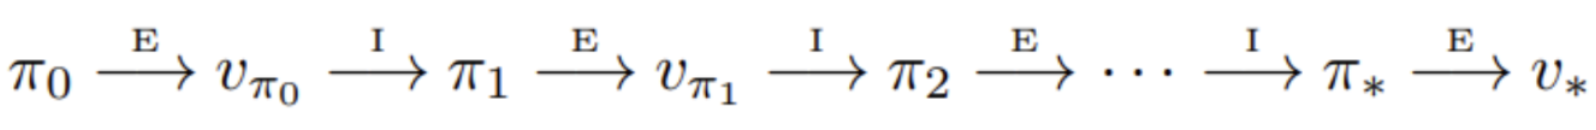



**Policy Evaluation**

The intial value function is initialized to be zero and each successive approximation is obtained via **Bellman equation**:
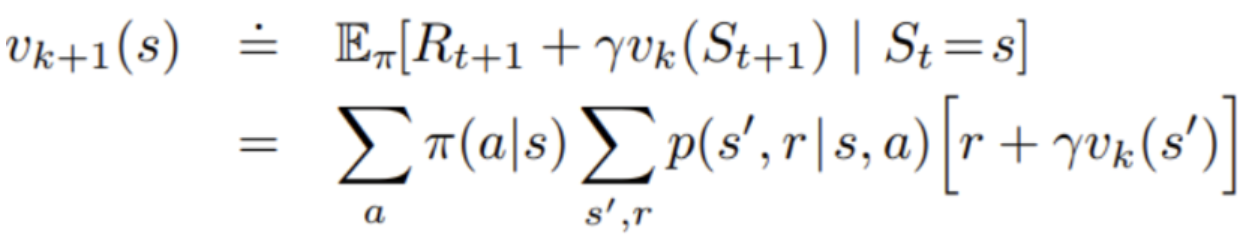
where
- *π(a|s)* = Probability of taking action a in state s under policy *π*

**Existence and uniqueness of value function are guaranteed when:**
- *γ < 1* or
- eventual termination is guaranteed from all states under policy *π*

In [5]:
def policy_evaluation(env,v_state,policy,discount_rate,no_iterations,converge_tol):

    for iter in range(no_iterations):
        v_state_next_iter = np.zeros(70)
        for s in env.P:
            v = 0
            for a in env.P[s]:
                sum = 0
                for prob, next_state, reward, is_terminal in env.P[s][a]:
                    sum = sum + prob*(reward + discount_rate*v_state[next_state])
                v = v + policy[s,a]*sum
            v_state_next_iter[s] = v
        if (np.max(np.abs(v_state_next_iter - v_state)) < converge_tol):
            v_state = v_state_next_iter
            print('Itarative Policy Evaluation Converged!!!')
            break
        v_state = v_state_next_iter

    return v_state

**Policy Improvement**

To determine whether to change to the new policy, select a in s following existing policy, π. Action value function:
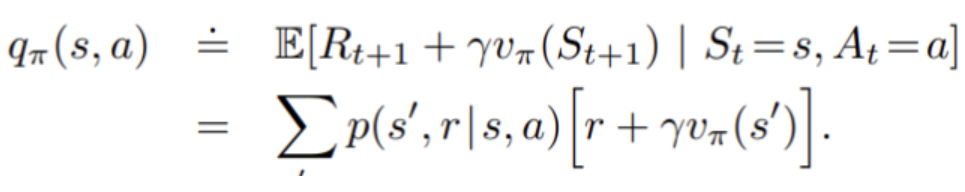

To perform policy improvement, let π and π’ be any pair of deterministic policies for all s in state set. If 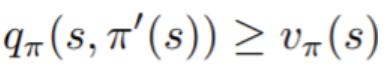

is true, then π’ must be better or as good as π. It must obtain greater of equal expected return form all s in state set:
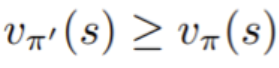

Then, select the new greedy policy, π’:
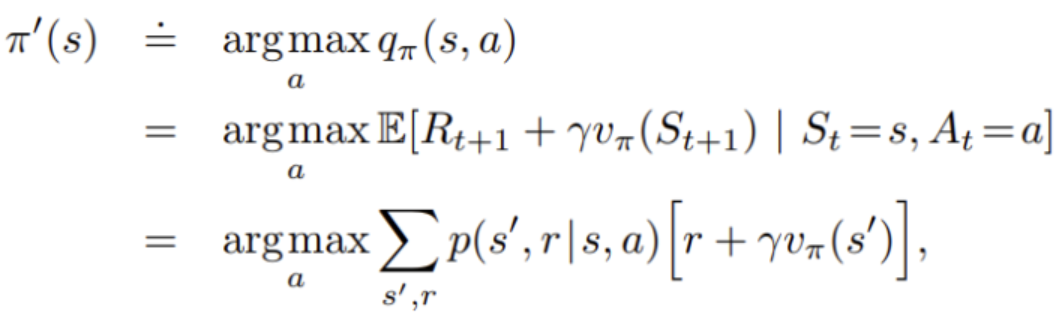

The new policy always better or else it is already optimal policy.

In [6]:
def policy_improvement(env,v_state,no_actions,no_states,discount_rate, q_table):

    q_matrix = np.zeros((no_states, no_actions))
    improved_policy = np.zeros((no_states, no_actions))

    for s in range(no_states):
        for a in range(no_actions):
            for prob, next_state, reward, is_terminal in env.P[s][a]:

                q_matrix[s,a] = q_matrix[s,a] + prob*(reward + discount_rate*v_state[next_state])

                if (s // env.grid_width, s % env.grid_width) not in q_table:
                    q_table[(s // env.grid_width, s % env.grid_width)] = q_matrix[s,:]

        best_action = np.where(q_matrix[s,:] == np.max(q_matrix[s,:]))

        improved_policy[s,best_action] = 1/np.size(best_action)

    return improved_policy,q_table

**Value Iteration**

Value iteration is done by stopping policy evaluation after just one update of each state. It is a simple update operation that combines the policy improvement and truncated policy evaluation steps:
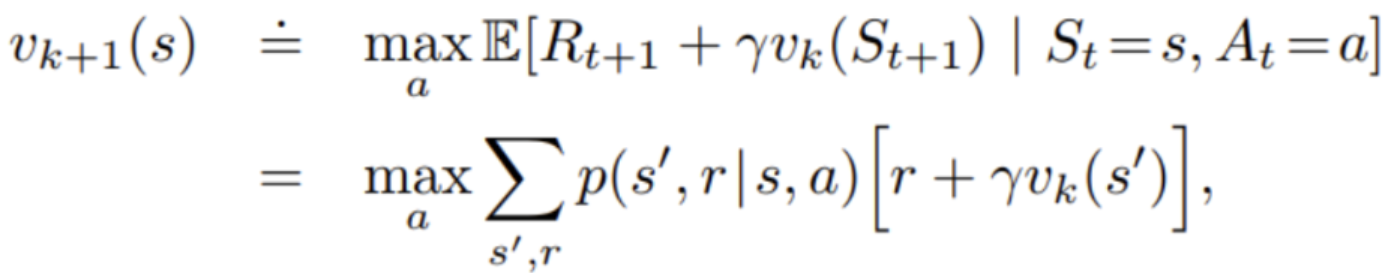

- Value iteration combines one policy evaluation and one policy improvement in each iteration.
- But faster convergence is achieved by including multiple policy evaluation between each policy improvement, hence policy iteration converges faster than value iteration.

In [7]:
def value_iteration(env,v_state,discount_rate,no_iterations,converge_tol):

    env.reset()

    value_function_value_iter = []

    for iter in range(no_iterations):
        v_state_next_iter = np.zeros(env.grid_height*env.grid_width)
        for s in env.P:
            v = []
            for a in env.P[s]:
                for prob, next_state, reward, is_terminal in env.P[s][a]:
                    v.append(prob*(reward + discount_rate * v_state[next_state]))

            v_state_next_iter[s] = max(v)
        if (np.max(np.abs(v_state_next_iter - v_state)) < converge_tol):
            v_state = v_state_next_iter
            print(f'Value Iteration Converged at Iteration {iter} !!!\n')
            print("Value State Function:\n", v_state)
            break
        v_state = v_state_next_iter
        value_function_value_iter.append(v_state)

    return v_state, value_function_value_iter

**Model for Windy Grid World with King's Move**

We customized the model for our Windy Grid World environment. It is in a double dictionary form. The key of the outer dictionary is the state number range from 0 to 69 (since we have environment size of 7x10). The value is an inner dictionary in which the key is the action number range from 0 to 7 (since we have 8 actions) while the value is a tuple containing information:
- probability of transitioning to next state
- next state
- reward
- done (check reach goal state or not)

In [8]:
def create_king_env_P(env):
    n_rows = env.grid_height
    n_cols = env.grid_width
    goal_state = env.goal_state[0]*10 + env.goal_state[1]
    # Create the "P" dictionary
    P = {}
    for s in range(no_states):
        P[s] = {}
        for a in range(no_actions):
            P[s][a] = []

            # Calculate the row and column indices from the state number
            row = s // n_cols
            col = s % n_cols

            # Define wind strength for each column
            wind_strength = env.wind

            # Define the possible next states based on the action
            if a == 0: # N
                next_row = max(0, row - 1 - wind_strength[col])
                next_col = col
            elif a == 1:  # NE
                next_row = max(row - 1 - wind_strength[col], 0)
                next_col = min(col + 1, env.grid_width - 1)
            elif a == 2:  # E
                next_row = max(row - wind_strength[col], 0)
                next_col = min(col + 1, env.grid_width - 1)
            elif a == 3:  # SE
                next_row = min(row + 1 - wind_strength[col], env.grid_height - 1)
                next_col = min(col + 1, env.grid_width - 1)
            elif a == 4:  # S
                next_row = min(row + 1 - wind_strength[col], env.grid_height - 1)
                next_col = col
            elif a == 5:  # SW
                next_row = min(row + 1 - wind_strength[col], env.grid_height - 1)
                next_col = max(col - 1, 0)
            elif a == 6:  # W
                next_row = max(row - wind_strength[col], 0)
                next_col = max(col - 1, 0)
            elif a == 7:  # NW
                next_row = max(row - 1 - wind_strength[col], 0)
                next_col = max(col - 1, 0)


            # Calculate the next state and reward
            next_state = next_row * n_cols + next_col
            reward = -1  # Define the reward

            # Check if the episode terminates when reached goal state
            done = False
            if next_state == goal_state:
                done = True
                reward = 0

            # Append the transition information to the "P" dictionary
            P[s][a].append((1.0, next_state, reward, done))

    return P

**Model for Stochastic Windy Grid World with King's Move**

In [9]:
def create_stochastic_king_env_P(env):
    n_rows = env.grid_height
    n_cols = env.grid_width
    goal_state = env.goal_state[0]*10 + env.goal_state[1]
    # Create the "P" dictionary
    P = {}
    for s in range(no_states):
        P[s] = {}
        for a in range(no_actions):
            P[s][a] = []

            # Calculate the row and column indices from the state number
            row = s // n_cols
            col = s % n_cols

            # Define wind strength for each column
            wind_strength = env.wind

            if wind_strength[col] > 0:
                # Apply stochastic wind effect
                stochastic_wind_effect = np.random.choice([-1, 0, 1], p=env.stochastic_wind_probability)
                wind_strength[col] *= stochastic_wind_effect

            # Define the possible next states based on the action
            if a == 0: # N
                next_row = clamp(row - 1 - wind_strength[col], 0, env.grid_height - 1)
                next_col = col
            elif a == 1:  # NE
                next_row = clamp(row - 1 - wind_strength[col], 0, env.grid_height - 1)
                next_col = min(col + 1, env.grid_width - 1)
            elif a == 2:  # E
                next_row = clamp(row - wind_strength[col], 0, env.grid_height - 1)
                next_col = min(col + 1, env.grid_width - 1)
            elif a == 3:  # SE
                #next_row = max(min(row + 1 - wind_strength[col], env.grid_height - 1), 0)
                next_row = clamp(row + 1 - wind_strength[col], 0, env.grid_height - 1)
                next_col = min(col + 1, env.grid_width - 1)
            elif a == 4:  # S
                #next_row = max(min(row + 1 - wind_strength[col], env.grid_height - 1), 0)
                next_row = clamp(row + 1 - wind_strength[col], 0, env.grid_height - 1)
                next_col = col
            elif a == 5:  # SW
                #next_row = max(min(row + 1 - wind_strength[col], env.grid_height - 1), 0)
                next_row = clamp(row + 1 - wind_strength[col], 0, env.grid_height - 1)
                next_col = max(col - 1, 0)
            elif a == 6:  # W
                next_row = clamp(row - wind_strength[col], 0, env.grid_height - 1)
                next_col = max(col - 1, 0)
            elif a == 7:  # NW
                next_row = clamp(row - 1 - wind_strength[col], 0, env.grid_height - 1)
                next_col = max(col - 1, 0)


            # Calculate the next state and reward
            next_state = next_row * n_cols + next_col
            reward = -1  # Define the reward

            # Check if the episode terminates when reached goal state
            done = False
            if next_state == goal_state:
                done = True
                reward = 0

            # Append the transition information to the "P" dictionary
            P[s][a].append((1.0, next_state, reward, done))

    return P

In [10]:
def custom_policy(state):
    return np.random.choice([0,1,2,3,4,5,6,7], p = current_policy[state])

#### Monte Carlo Control

**On Policy First Visit**

Monte Carlo methods are particularly suitable when there is a need to learn from direct interaction with the environment. They provide a way to balance exploration and exploitation while gradually improving the policy based on observed returns.

Our environment and rewards mechanism does not work well with every-visit Monte Carlo, as it needs to terminate while having negative rewards every timestep, thus we chose first-visit.

It is an on policy algorithm because it updates the policy based on actions taken. Pseudocode shown below:

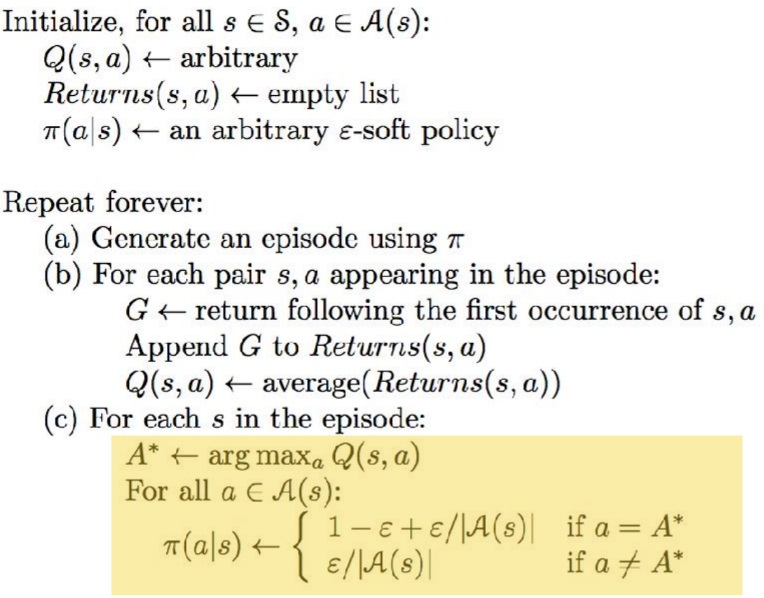

In [50]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
            
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [48]:
def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards))])

    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Gt = sum(rewards[i:] * discounts[:len(rewards)-i])
        Q[state][actions[i]] = old_Q + alpha * (Gt - old_Q)

    return Q

def firstVisitOnPolicy(env, num_episodes, alpha, gamma=0.9, eps_start=0.3, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    episode_rewards = []

    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)

        total_reward = sum([r for (_, _, r) in episode])
        episode_rewards.append(total_reward)

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, episode_rewards

#### Temporal Difference Learning

**SARSA(0) On-Policy**

State-action-reward-state-action (SARSA) is an on-policy reinforcement learning algorithm used to teach a new Markov Decision Process policy in order to solve reinforcement learning challenges.

In the current state (S), an action (A) is taken and the agent gets a reward (R), and ends up in the next state (S1), and takes action (A1) in S1. Therefore, the tuple (S,A,R,S1,A1) stands for the acronym SARSA.

It is an on policy algorithm because it updates the policy based on actions taken. The pseudocode of SARSA is as the image below:

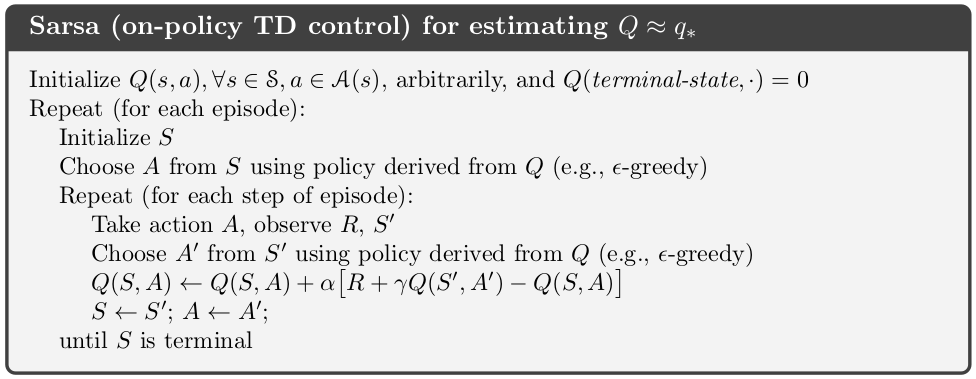

In [13]:
def epsilon_greedy(q_values, epsilon, num_actions):
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values)

def sarsa(env, num_episodes, alpha, gamma, epsilon):
    q_table = {}
    episode_rewards = []
    step_episode_list = []
    path = []

    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy(q_table.get(state, np.zeros(env.action_space.n)), epsilon, env.action_space.n)
        total_reward = 0
        episode_step_count = 0
        episode_path = [state]

        while True:
            next_state, reward, done, _ = env.step(action)
            next_action = epsilon_greedy(q_table.get(next_state, np.zeros(env.action_space.n)), epsilon, env.action_space.n)

            if state not in q_table:
                q_table[state] = np.zeros(env.action_space.n)

            q_table[state][action] += alpha * (reward + gamma * q_table.get(next_state, np.zeros(env.action_space.n))[next_action] - q_table[state][action])

            total_reward += reward
            state = next_state
            action = next_action
            episode_step_count += 1
            episode_path.append(state)

            if done:
                episode_rewards.append(total_reward)
                step_episode_list.append(episode_step_count)
                path.append(episode_path)
                break

    return q_table, episode_rewards, step_episode_list

**Expected SARSA**

Expected SARSA is similar to Q-Learning; however, instead of taking the maximum over the next state-action pairs, it uses expected value, taking into account how likely each action is under the current policy. The update equation is as below:<br>

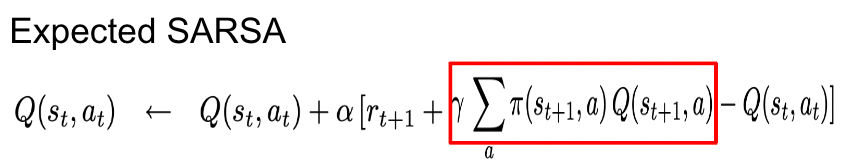

<br>Given the next state S(t+1), Expected SARSA moves deterministically in the same direction as SARSA moves in expectation, and so is called Expected SARSA. It is more computationally complex than SARSA but in return, it eliminates the variance due to random selection of A(t+1). The pseudocode of Expected SARSA is as below:<br>

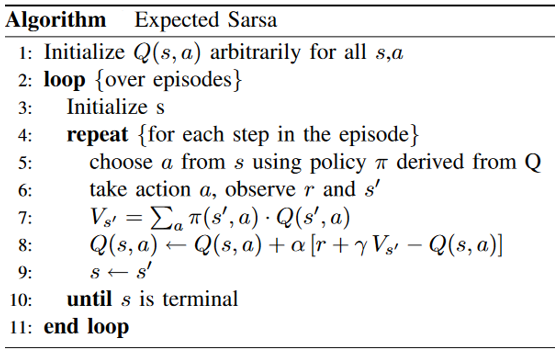

In [14]:
def epsilon_greedy(q_values, epsilon, num_actions):
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values)

def expected_sarsa(env, num_episodes, alpha, gamma, epsilon):
    q_table = {}
    episode_rewards = []
    step_episode_list = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        episode_step_count = 0

        while True:

            if state not in q_table:
                q_table[state] = np.zeros(env.action_space.n)

            action = epsilon_greedy(q_table[state], epsilon, env.action_space.n)
            next_state, reward, done, _ = env.step(action)

            if next_state not in q_table:
                q_table[next_state] = np.zeros(env.action_space.n)

            # Calculate the expected value of the action-values using epsilon-greedy policy
            expected_q = np.dot(q_table[next_state], np.ones(env.action_space.n) * epsilon / env.action_space.n) + \
                         (1 - epsilon) * np.max(q_table[next_state])

            q_table[state][action] += alpha * (reward + gamma * expected_q - q_table[state][action])

            total_reward += reward
            state = next_state
            episode_step_count += 1

            if done:
                episode_rewards.append(total_reward)
                step_episode_list.append(episode_step_count)
                break

    return q_table, episode_rewards, step_episode_list

**Q-Learning**

Q-learning is a model-free reinforcement learning algorithm that is used to find the optimal action-selection policy for a given finite Markov decision process (MDP). The basic idea behind Q-learning is to learn a Q-function, which represents the expected cumulative rewards of taking a particular action in a particular state and following the optimal policy thereafter. The following equation explains the Q function updates: <br>

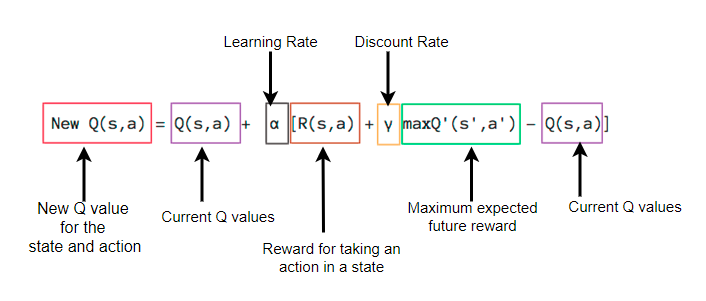

<br>The Q-learning algorithm iteratively updates the Q-values based on the observed rewards and the expected future rewards. α is the learning rate which controls how much the new information is used based on the old information. γ is the discount factor which discounts expected future rewards. During the learning process, the agent needs to balance exploration and exploitation. This is typically addressed using an epsilon-greedy strategy, where the agent selects the best-known action with probability 1−ϵ and explores a new action with probability ϵ. The pseudocode of Q-learning is as below:<br>
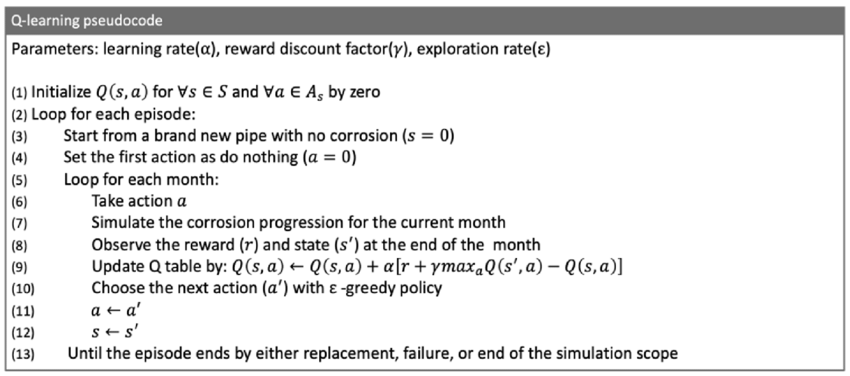

In [15]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_prob=1.0, exploration_decay=0.995):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.exploration_decay = exploration_decay
        self.q_table = np.zeros((env.grid_height, env.grid_width, env.nA))

    def choose_action(self, state):
        if np.random.rand() < self.exploration_prob:
            return np.random.choice(self.env.nA)
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (
            reward + self.discount_factor * self.q_table[next_state][best_next_action] - self.q_table[state][action])

    def train(self, num_episodes):
        rewards = []
        step_counts = []  # To store the number of steps taken in each episode

        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            step_count = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)

                total_reward += reward
                step_count += 1
                state = next_state

                if done:
                    break

            rewards.append(total_reward)
            step_counts.append(step_count)
            self.exploration_prob *= self.exploration_decay

        return self.q_table, rewards, step_counts

def q_learning_grid_search(env, alphas, gammas, num_episodes):
    results = {}
    rewards = {}
    step_counts = {}

    for alpha in alphas:
        for gamma in gammas:
            agent = QLearningAgent(env, learning_rate=alpha, discount_factor=gamma)
            q_table, episode_rewards, episode_steps = agent.train(num_episodes)
            results[(alpha, gamma)] = q_table
            rewards[(alpha, gamma)] = episode_rewards
            step_counts[(alpha, gamma)] = episode_steps

    return results, rewards, step_counts

**N-Step SARSA**

N-step SARSA (State-Action-Reward-State-Action) is a temporal-difference reinforcement learning algorithm which is the combination of the original SARSA algorithm and Monte Carlo algorithm by considering the cumulative reward over multiple time steps. This extension allows the algorithm to capture the effects of actions over a more extended period, providing a balance between short-term and long-term considerations.<br>
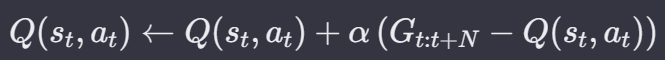

<br>α is the learning rate whereas
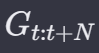 is the which is the sum of the rewards over the next N steps plus the estimated value of the state  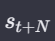
using the current Q-values. <br>

<br>N-step SARSA involves bootstrapping, where the agent estimates the value of a state based on its current Q-values and updates those Q-values accordingly. Similar to SARSA and Q-learning, N-step SARSA often uses an epsilon-greedy strategy to balance exploration and exploitation. The pseudocode is as below:<br>
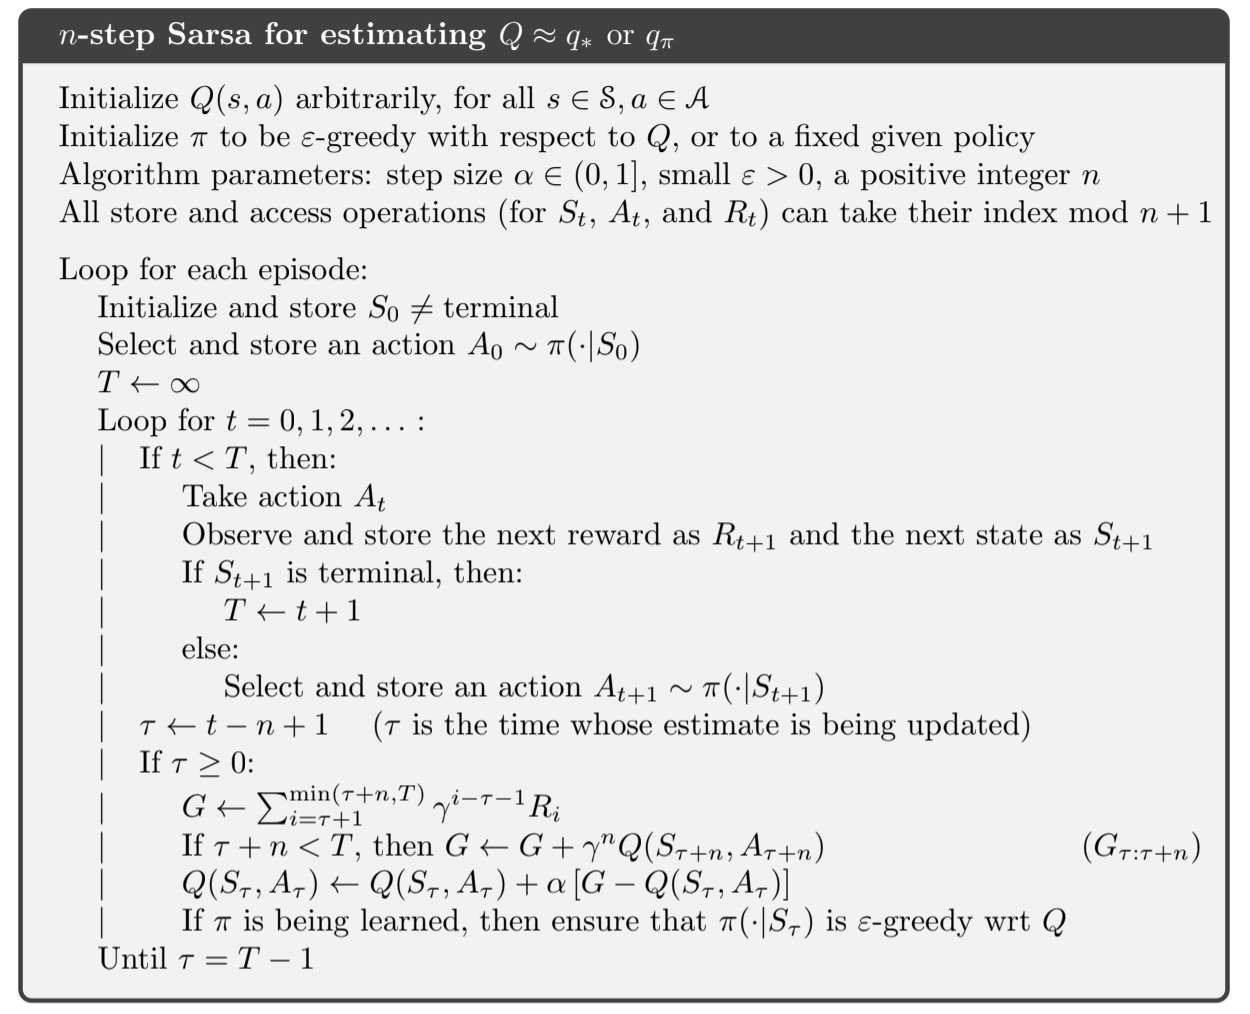

In [16]:
def epsilon_greedy(q_values, epsilon, num_actions):
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values)


def n_step_sarsa(env, num_episodes, n, alpha, gamma, epsilon):
    q_table = {}
    episode_rewards_list = []
    step_episode_list = []
    path = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_states = [state]
        episode_actions = []
        episode_rewards = []  # Change this variable name to avoid conflicts
        t = 0
        T = float('inf')

        while True:
            if t < T:
                action = epsilon_greedy(q_table.get(state, np.zeros(env.action_space.n)), epsilon, env.action_space.n)
                episode_actions.append(action)

                next_state, reward, done, _ = env.step(action)
                episode_states.append(next_state)
                episode_rewards.append(reward)

                if done:
                    T = t + 1

            tau = t - n + 1
            if tau >= 0:
                G = sum([gamma**(i - tau - 1) * episode_rewards[i] for i in range(tau + 1, min(tau + n, T))])
                if tau + n < T:
                    G += gamma**n * q_table.get(episode_states[tau + n], np.zeros(env.action_space.n))[epsilon_greedy(q_table.get(episode_states[tau + n], np.zeros(env.action_space.n)), epsilon, env.action_space.n)]

                state_to_update = episode_states[tau]
                action_to_update = episode_actions[tau]
                if state_to_update not in q_table:
                    q_table[state_to_update] = np.zeros(env.action_space.n)
                q_table[state_to_update][action_to_update] += alpha * (G - q_table[state_to_update][action_to_update])

            if tau == T - 1:
                break

            t += 1
            state = next_state

        # Store episode rewards separately to avoid conflicts with the outer loop variable
        episode_rewards_list.append(sum(episode_rewards))
        step_episode_list.append(len(episode_states) - 1)  # Subtract 1 to get the step count

    return q_table, episode_rewards_list, step_episode_list

#### Monte Carlo Tree Search (MCTS)

The process of MCTS can broken down into 4 steps:

**1. Selection**
- traverse the current tree from root node using following strategy
- select the nodes with highest estimated value using Upper Confidence Bound (UCB)
- balance the exploration-exploitation trade-off
- UCB formula:
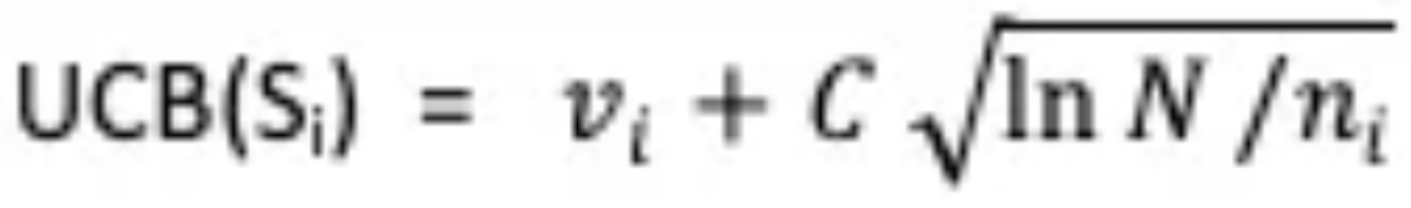

where
- Si : value of node i
- vi : empirical mean of node i
- C : constant
- N : total number of simulations

**2. Expansion**
- add a new child node to the tree to that node which was optimally reached in selection process

**3. Simulation**
- choose moves or strategies until predefined state is achieved

**4. Backpropagation**
- update the remaining tree after determining the value of new node
- backpropagate from new node to root node
- increase number of simulation
- increase number of wins, if new node's simulation reach goal state


In [17]:
c = 1.0

class Node:

    '''
    The Node class represents a node of the MCTS tree.
    It contains the information needed for the algorithm to run its search.
    '''

    def __init__(self, game, done, parent, observation, action_index):

        # child nodes
        self.child = None

        # total rewards from MCTS exploration
        self.T = 0

        # visit count
        self.N = 0

        # the environment
        self.game = game

        # observation of the environment
        self.observation = observation

        # if game is won/loss/draw
        self.done = done

        # link to parent node
        self.parent = parent

        # action index that leads to this node
        self.action_index = action_index


    def getUCBscore(self):

        '''
        This is the formula that gives a value to the node.
        The MCTS will pick the nodes with the highest value.
        '''

        # Unexplored nodes have maximum values so we favour exploration
        if self.N == 0:
            return float('inf')

        # We need the parent node of the current node
        top_node = self
        if top_node.parent:
            top_node = top_node.parent

        # We use one of the possible MCTS formula for calculating the node value
        return (self.T / self.N) + c * math.sqrt(math.log(top_node.N) / self.N)


    def detach_parent(self):
        # free memory detaching nodes
        del self.parent
        self.parent = None


    def create_child(self):

        '''
        We create one children for each possible action of the game,
        then we apply such action to a copy of the current node enviroment
        and create such child node with proper information returned from the action executed
        '''

        if self.done:
            return

        actions = []
        games = []
        for i in range(0, 8):
            actions.append(i)
            new_game = deepcopy(self.game)
            games.append(new_game)

        child = {}
        for action, game in zip(actions, games):
            observation, reward, done, _ = game.step(action)
            child[action] = Node(game, done, self, observation, action)

        self.child = child


    def explore(self):

        '''
        The search along the tree is as follows:
        - from the current node, recursively pick the children which maximizes the value according to the MCTS formula
        - when a leaf is reached:
            - if it has never been explored before, do a rollout and update its current value
            - otherwise, expand the node creating its children, pick one child at random, do a rollout and update its value
        - backpropagate the updated statistics up the tree until the root: update both value and visit counts
        '''

        current_iter = 0
        # find a leaf node by choosing nodes with max U.

        current = self

        while current.child:

            child = current.child
            max_U = max(c.getUCBscore() for c in child.values())
            actions = [ a for a,c in child.items() if c.getUCBscore() == max_U ]
            if len(actions) == 0:
                print("error zero length ", max_U)
            action = random.choice(actions)
            current = child[action]

        # play a random game, or expand if needed

        if current.N < 1:
            current.T = current.T + current.rollout()
        else:
            current.create_child()
            if current.child:
                current = random.choice(current.child)
            current.T = current.T + current.rollout()

        current.N += 1

        # update statistics and backpropagate

        parent = current

        while parent.parent:

            parent = parent.parent
            parent.N += 1
            parent.T = parent.T + current.T

        root_average_value = current.T / current.N if current.N > 0 else 0

        average_values.append(root_average_value)

    def rollout(self):

        '''
        The rollout is a random play from a copy of the environment of the current node using random moves.
        This will give us a value for the current node.
        Taken alone, this value is quite random, but, the more rollouts we will do for such node,
        the more accurate the average of the value for such node will be. This is at the core of the MCTS algorithm.
        '''

        if self.done:
            return 0

        v = 0
        done = False
        new_game = deepcopy(self.game)
        while not done:
            action = new_game.action_space.sample()
            observation, reward, done, _ = new_game.step(action)
            v = v + reward
            if done:
                new_game.reset()
                new_game.close()
                break
        return v


    def next(self):

        '''
        Once we have done enough search in the tree, the values contained in it should be statistically accurate.
        We will at some point then ask for the next action to play from the current node, and this is what this function does.
        There may be different ways on how to choose such action, in this implementation the strategy is as follows:
        - pick at random one of the node which has the maximum visit count, as this means that it will have a good value anyway.
        '''

        if self.done:
            raise ValueError("game has ended")

        if not self.child:
            raise ValueError('no children found and game hasn\'t ended')

        child = self.child

        max_N = max(node.N for node in child.values())

        max_children = [ c for a,c in child.items() if c.N == max_N ]

        if len(max_children) == 0:
            print("error zero length ", max_N)

        max_child = random.choice(max_children)

        return max_child, max_child.action_index

MCTS_POLICY_EXPLORE = 100 # MCTS exploring constant: the higher, the more reliable, but slower in execution time

def Policy_Player_MCTS(mytree):

    '''
    Our strategy for using the MCTS is quite simple:
    - in order to pick the best move from the current node:
        - explore the tree starting from that node for a certain number of iterations to collect reliable statistics
        - pick the node that, according to MCTS, is the best possible next action
    '''

    for i in range(MCTS_POLICY_EXPLORE):
        mytree.explore()

    next_tree, next_action = mytree.next()

    # note that here we are detaching the current node and returning the sub-tree
    # that starts from the node rooted at the choosen action.
    # The next search, hence, will not start from scratch but will already have collected information and statistics
    # about the nodes, so we can reuse such statistics to make the search even more reliable!
    next_tree.detach_parent()

    return next_tree, next_action

### Run Experiment on All Methods

#### Windy Grid World with King's Move

#### Dynamic Programming

**Policy Iteration**

In [18]:
env = WindyGridWorldEnvKingsMove()

env.reset()
env.render()
#env.close()

print(env.observation_space)

print(env.action_space)

discount_rate = 0.9

no_states = env.grid_height*env.grid_width

no_actions = len(env.actions)

no_iterations = 1000

v_state_initial = np.zeros(no_states)
initial_policy=(1/no_actions)*np.ones((no_states,no_actions))

convergence_tol = 10**(-6)

Rendering Human Mode
Tuple(Discrete(7), Discrete(10))
Discrete(8)


In [19]:
env.P = create_king_env_P(env)

In [20]:
value_function_policy_iter = []

start = time.time()

for iter in range(no_iterations):
    q = {}
    print("Iteration - {} - of policy iteration algorithm".format(iter))
    if (iter == 0):
        current_policy = initial_policy
    v_state = policy_evaluation(env,v_state_initial,current_policy,discount_rate,no_iterations,convergence_tol)
    #print(v_state)

    value_function_policy_iter.append(v_state)

    improved_policy,q = policy_improvement(env,v_state,no_actions,no_states,discount_rate, q)

    if np.allclose(current_policy,improved_policy):
        current_policy = improved_policy
        print(f"\nPolicy Iteration Algorithm converged")
        break
    current_policy = improved_policy

end = time.time()
total_time = end - start
print("\nTotal Runtime for Policy Iteration:", str(total_time), "second")

Iteration - 0 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 1 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 2 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 3 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 4 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 5 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!

Policy Iteration Algorithm converged

Total Runtime for Policy Iteration: 0.23195171356201172 second


The policy iteration algorithm converged in 6 iterations.

Rendering Agent Mode


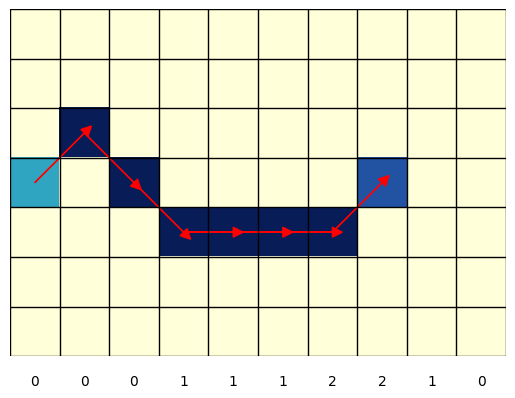

Total Reward: -6


In [21]:
env.render(mode='agent', q_table=q)

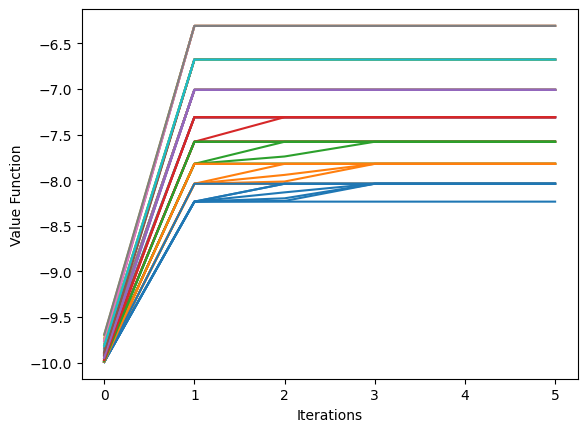

In [22]:
plt.plot(value_function_policy_iter)
plt.xlabel('Iterations')
plt.ylabel('Value Function')
plt.show()

The graph above visualizes that the policy iteration converged in 6 iterations. Some states already converged in iteration 1 while some states converged in iteration 2 or 3.

**Value Iteration**

In [23]:
start = time.time()

v_state, v_value_iter = value_iteration(env,v_state_initial,discount_rate,no_iterations,convergence_tol)

end = time.time()
total_time = end - start
print("\nTotal Runtime for Monte Carlo First Visit:", str(total_time), "second")

Value Iteration Converged at Iteration 132 !!!

Value State Function:
 [-8.23506161 -8.03895734 -7.82106463 -7.57896161 -7.30995734 -7.01106463
 -6.67896161 -6.67896161 -7.01106463 -7.30995734 -8.03895734 -8.03895734
 -7.82106463 -7.57896161 -7.30995734 -7.01106463 -7.01106463 -7.01106463
 -7.01106463 -7.01106463 -8.03895734 -7.82106463 -7.82106463 -7.57896161
 -7.30995734 -7.01106463 -7.01106463 -7.01106463 -7.01106463 -6.67896161
 -8.03895734 -7.82106463 -7.57896161 -7.57896161 -7.30995734 -7.30995734
 -7.01106463 -7.01106463 -6.30995734 -6.67896161 -8.03895734 -7.82106463
 -7.57896161 -7.30995734 -7.01106463 -6.67896161 -6.30995734 -6.30995734
 -6.30995734 -6.67896161 -8.03895734 -7.82106463 -7.57896161 -7.30995734
 -7.01106463 -6.67896161 -6.30995734 -6.67896161 -6.30995734 -6.67896161
 -8.03895734 -7.82106463 -7.57896161 -7.30995734 -7.01106463 -6.67896161
 -6.30995734 -6.30995734 -6.67896161 -6.67896161]

Total Runtime for Monte Carlo First Visit: 0.029998779296875 second


The value iteration algorithm converged at iteration 132 and the optimal value function is shown above.

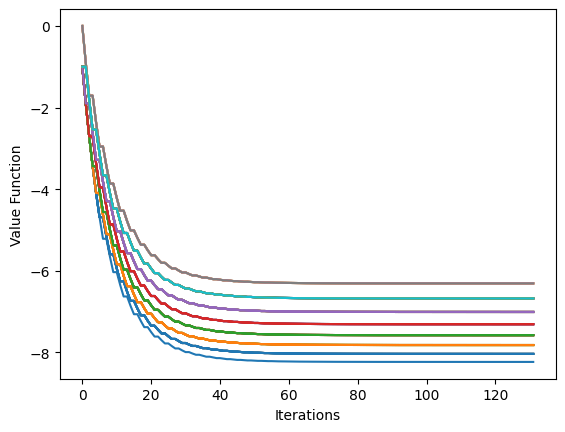

In [24]:
plt.plot(v_value_iter)
plt.xlabel('Iterations')
plt.ylabel('Value Function')
plt.show()

Above graph visualizes the value iteration algorithm which converged at iteration 132. The value function decrease rapidly in first 20 iterations. Then it decreases gently in following iterations and converged in iteration 132.

#### Monte Carlo Control

**First Visit On Policy**

Step Size (alpha) selection: 0.005, 0.01, 0.1

Number of episodes: 20000

In [55]:
num_episodes = 20000
env = WindyGridWorldEnvKingsMove()
results = {}

In [56]:
alpha = 0.005
print("Now running alpha:", alpha)
_, _, episode_rewards = firstVisitOnPolicy(env, num_episodes, alpha=alpha)
results[alpha] = episode_rewards

Now running alpha: 0.005
Episode 20000/20000.

In [57]:
alpha = 0.01
print("Now running alpha:", alpha)
_, _, episode_rewards = firstVisitOnPolicy(env, num_episodes, alpha=alpha)
results[alpha] = episode_rewards

Now running alpha: 0.01
Episode 20000/20000.

In [59]:
alpha = 0.1
print("Now running alpha:", alpha)
_, _, episode_rewards = firstVisitOnPolicy(env, num_episodes, alpha=alpha)
results[alpha] = episode_rewards

Now running alpha: 0.1
Episode 20000/20000.

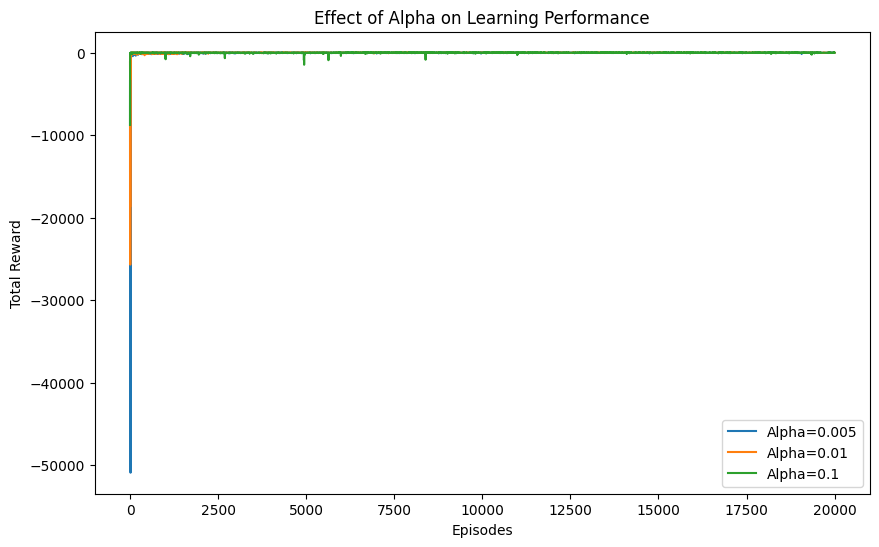

In [60]:
# Plot a graph for step_ep_list for all parameter combinations
plt.figure(figsize=(10, 6))
for alpha, reward in results.items():
    plt.plot(range(len(reward)), reward, label=f"Alpha={alpha}")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title('Effect of Alpha on Learning Performance')
plt.legend()
plt.show()

In [61]:
windy_mc_best_parameter = None
best_reward = float('-inf')

for alpha in alphas:
    reward = np.sum(results[alpha])
    if reward > best_reward:
        best_reward = reward
        windy_mc_best_parameter = alpha

print("Best Alpha:", windy_mc_best_parameter)

Best Alpha: 0.1


In [63]:
# obtain the estimated optimal policy and action-value function

start = time.time()

env = WindyGridWorldEnvKingsMove()
policy, Q, _ = firstVisitOnPolicy(env, 30000, alpha=windy_mc_best_parameter)

end = time.time()
total_time = end - start
print("\nTotal Runtime for Monte Carlo First Visit:", str(total_time), "second")

Episode 30000/30000.
Total Runtime for Monte Carlo First Visit: 367.15100502967834 second


Rendering Agent Mode


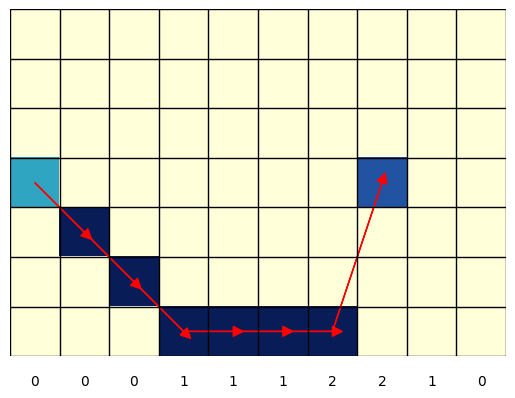

Total Reward: -6


In [64]:
env.render(mode='agent', q_table = Q)

> **Inferences (Monte Carlo Control)**

* The best step size for Monte Carlo is 0.1
* The larger step sizes converges faster, but are far more inconsistent after it converges

#### Temporal Difference Learning

**SARSA(0)**

> **Hyperparameter Selection (SARSA)**

|Hyperparameter|Selection|Explanation|
|:-:|:--|:--|
|Epsilon|[0.1, 0.2]|- Parameters for epsilon greedy.<br>- Epsilon is the probability of choosing to explore |
|Alpha|[0.5, 0.6, 0.7]|Learning Rate|
|Gamma|[0.9, 1]|- Discount Factor<br>- It is advised to be closer to 1|

In [65]:
# Parameter to tune
num_episodes = 2000
epsilons = [0.1, 0.2]
alphas = [0.5, 0.6, 0.7]
gammas = [0.9, 1]

num_episodes=200
results = {}
rewards = {}
step_ep_lists = {}
paths = {}

# Grid Search Hyperparameter Tuning
for epsilon in epsilons:
    for alpha in alphas:
        for gamma in gammas:
            env = WindyGridWorldEnvKingsMove()
            q_table, episode_rewards, episode_steps = sarsa(env, num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)
            results[(alpha, epsilon, gamma)] = q_table
            rewards[(alpha, epsilon, gamma)] = episode_rewards
            step_ep_lists[(alpha, epsilon, gamma)] = episode_steps

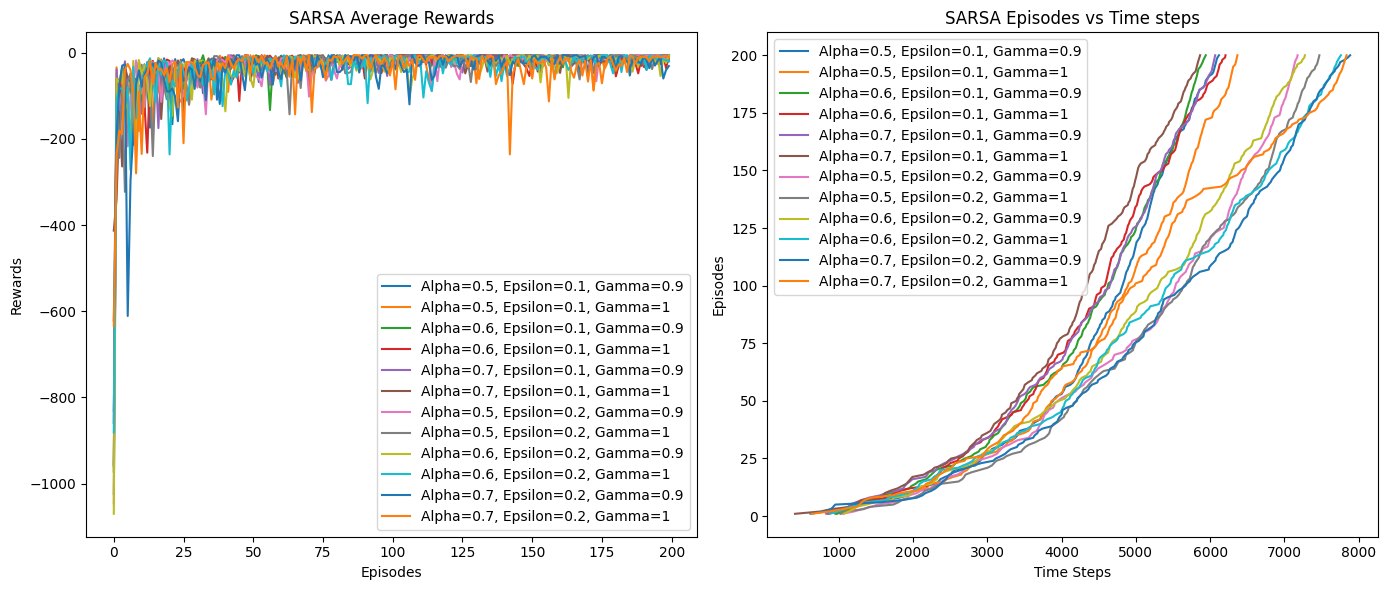

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for (alpha, epsilon, gamma), reward in rewards.items():
    axs[0].plot(range(len(reward)), reward, label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}")

axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Rewards")
axs[0].set_title('SARSA Average Rewards', fontsize='large')
axs[0].legend()

# Plotting Episodes vs Time steps
for (alpha, epsilon, gamma), step_ep_list in step_ep_lists.items():
    axs[1].plot(np.cumsum(step_ep_list), range(1, num_episodes + 1), label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}")

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Episodes")
axs[1].set_title('SARSA Episodes vs Time steps', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

In [67]:
windy_sarsa_best_parameter = None
best_reward = float('-inf')

for alpha in alphas:
    for epsilon in epsilons:
        for gamma in gammas:
            reward = np.sum(rewards[(alpha, epsilon, gamma)])
            if reward > best_reward:
                best_reward = reward
                windy_sarsa_best_parameter = (alpha, epsilon, gamma)

print("Best Parameter Combination (alpha, epsilon, gamma):", windy_sarsa_best_parameter)

Best Parameter Combination (alpha, epsilon, gamma): (0.7, 0.1, 1)


In [68]:
# Define parameters
num_episodes = 350
alpha = windy_sarsa_best_parameter[0]
epsilon = windy_sarsa_best_parameter[1]
gamma = windy_sarsa_best_parameter[2]

start = time.time()

env = WindyGridWorldEnvKingsMove()
sarsa_q_table, sarsa_episode_rewards, sarsa_episode_steps = sarsa(env, num_episodes, alpha, gamma, epsilon)

end = time.time()
total_time = end - start
print("\nTotal Runtime for SARSA(0):", str(total_time), "second")


Total Runtime for SARSA(0): 0.1561141014099121 second


Rendering Agent Mode


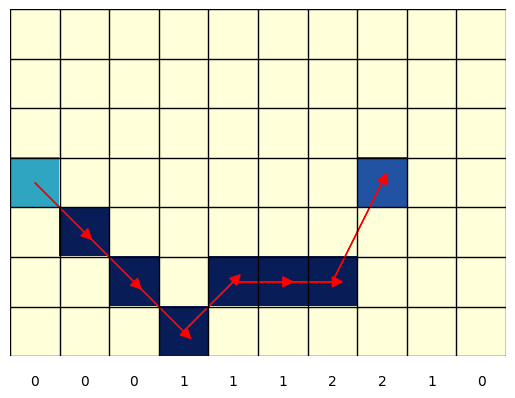

Total Reward: -6


In [69]:
env.render(mode='agent', q_table=sarsa_q_table)

> **Inferences (SARSA)**

* The best parameter for SARSA is (alpha, epsilon, gamma): (0.7, 0.1, 0.9).
* SARSA converges very fast. Based on the experiment, SARSA with the best parameters can converge within 350 episodes.
* The best reward for SARSA is -6, which means it took minimum of 6 steps to reach the goal state.

**Expected SARSA**

In [70]:
# Parameter to tune
epsilons = [0.1, 0.2]
alphas = [0.2, 0.5, 0.7]
gammas = [0.9, 1]

num_episodes=2000
results = {}
rewards = {}
step_ep_lists = {}

# Grid Search Hyperparameter Tuning
for epsilon in epsilons:
    for alpha in alphas:
        for gamma in gammas:
            env = WindyGridWorldEnvKingsMove()
            q_table, episode_rewards, episode_steps = expected_sarsa(env, num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)
            results[(alpha, epsilon, gamma)] = q_table
            rewards[(alpha, epsilon, gamma)] = episode_rewards
            step_ep_lists[(alpha, epsilon, gamma)] = episode_steps

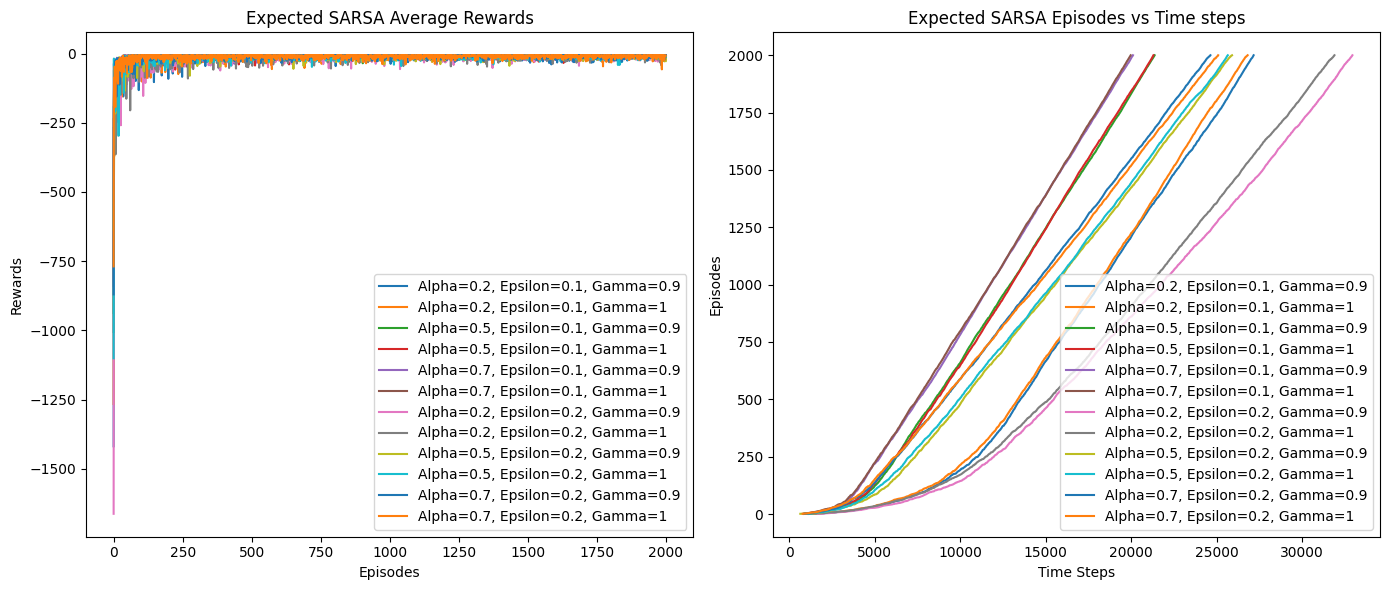

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for (alpha, epsilon, gamma), reward in rewards.items():
    axs[0].plot(range(len(reward)), reward, label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}")

axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Rewards")
axs[0].set_title('Expected SARSA Average Rewards', fontsize='large')
axs[0].legend()

# Plotting Episodes vs Time steps
for (alpha, epsilon, gamma), step_ep_list in step_ep_lists.items():
    axs[1].plot(np.cumsum(step_ep_list), range(1, num_episodes + 1), label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}")

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Episodes")
axs[1].set_title('Expected SARSA Episodes vs Time steps', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

In [72]:
windy_expected_sarsa_best_parameter = None
best_reward = float('-inf')

for alpha in alphas:
    for epsilon in epsilons:
        for gamma in gammas:
            reward = np.sum(rewards[(alpha, epsilon, gamma)])
            if reward > best_reward:
                best_reward = reward
                windy_expected_sarsa_best_parameter = (alpha, epsilon, gamma)

print("Best Parameter Combination (alpha, epsilon, gamma):", windy_expected_sarsa_best_parameter)

Best Parameter Combination (alpha, epsilon, gamma): (0.7, 0.1, 1)


In [74]:
# Define your parameters
num_episodes = 150
alpha = windy_expected_sarsa_best_parameter[0]
epsilon = windy_expected_sarsa_best_parameter[1]
gamma = windy_expected_sarsa_best_parameter[2]

start = time.time()

env = WindyGridWorldEnvKingsMove()
expected_sarsa_q_table, expected_sarsa_episode_rewards, expected_sarsa_episode_steps = expected_sarsa(env, num_episodes, alpha, gamma, epsilon)

end = time.time()
total_time = end - start
print("\nTotal Runtime for Expected SARSA:", str(total_time), "second")


Total Runtime for Expected SARSA: 0.22169137001037598 second


Rendering Agent Mode


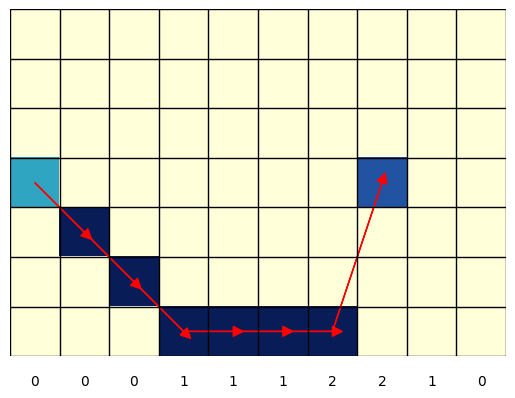

Total Reward: -6


In [75]:
env.render(mode='agent', q_table=expected_sarsa_q_table)

> **Inferences (Expected SARSA)**

* The best parameter for Expected SARSA is (alpha, epsilon, gamma): (0.8, 0.1, 0.9).
* Although Expected SARSA need more expensive computational cost than SARSA, it converged in fewer episodes, which is within 100 episodes.
* The best reward is -6, which means it took minimum of 6 steps to reach the goal state.

**Q-Learning**

> **Hyperparameter Selection (Q-Learning)**

|Hyperparameter|Selection|Explanation|
|:-:|:--|:--|
|Alpha|[0.1, 0.2, 0.3]|Learning Rate|
|Gamma|[0.9, 0.95, 1]|- Discount Factor<br>- It is advised to be closer to 1|

In [76]:
# Create WindyGridWorldEnvKingsMove environment
env = WindyGridWorldEnvKingsMove()

# Parameter grid for learning rate and discount factor
alphas = [0.1, 0.2, 0.3]
gammas = [0.9, 0.95, 1.0]
num_episodes = 200
# Perform Q-learning grid search
results, rewards, steps_counts = q_learning_grid_search(env, alphas, gammas, num_episodes=200)

# Visualize the learned path for the best set of hyperparameters
best_alpha, best_gamma = max(results, key=lambda key: np.mean(rewards[key]))
best_q_table = results[(best_alpha, best_gamma)]
best_agent = QLearningAgent(env, learning_rate=best_alpha, discount_factor=best_gamma)
best_agent.q_table = best_q_table


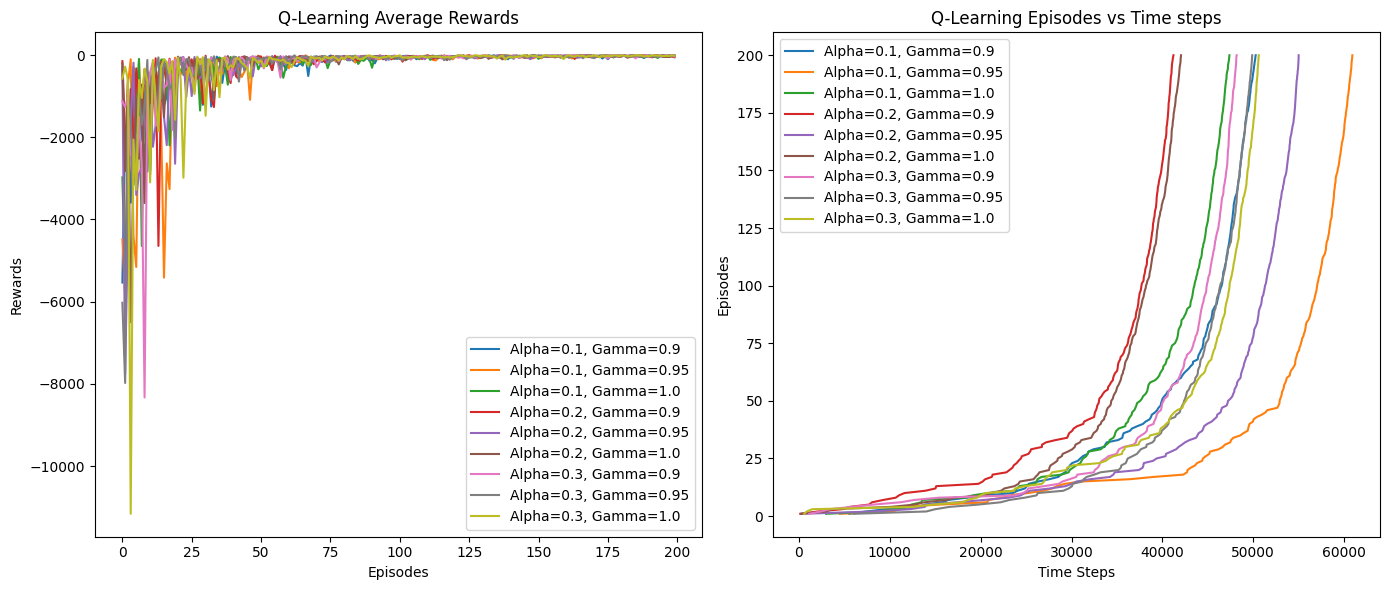

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for (alpha, gamma), reward in rewards.items():
    axs[0].plot(range(len(reward)), reward, label=f"Alpha={alpha}, Gamma={gamma}")

axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Rewards")
axs[0].set_title('Q-Learning Average Rewards', fontsize='large')
axs[0].legend()

# Plotting Episodes vs Time steps
for (alpha, gamma), steps in steps_counts.items():
    axs[1].plot(np.cumsum(steps), range(1, num_episodes + 1), label=f"Alpha={alpha}, Gamma={gamma}")

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Episodes")
axs[1].set_title('Q-Learning Episodes vs Time steps', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

In [78]:
windy_q_learning_best_parameter = None
best_reward = float('-inf')

for alpha in alphas:
    for gamma in gammas:
        reward = np.sum(rewards[(alpha, gamma)])
        if reward > best_reward:
            best_reward = reward
            windy_q_learning_best_parameter = (alpha, gamma)

print("Best Parameter Combination (alpha, gamma):", windy_q_learning_best_parameter)

Best Parameter Combination (alpha, gamma): (0.2, 0.9)


In [81]:
# Define parameters
num_episodes = 200
alpha = windy_q_learning_best_parameter[0]
gamma = windy_q_learning_best_parameter[1]

start = time.time()

env = WindyGridWorldEnvKingsMove()
q_learning_agent = QLearningAgent(env, learning_rate=alpha, discount_factor=gamma)
q_learning_q_table, q_learning_episode_rewards, q_learning_episode_steps = q_learning_agent.train(num_episodes)

end = time.time()
total_time = end - start
print("\nTotal Runtime for Q-Learning:", str(total_time), "second")


Total Runtime for Q-Learning: 1.286052942276001 second


Rendering Agent Mode


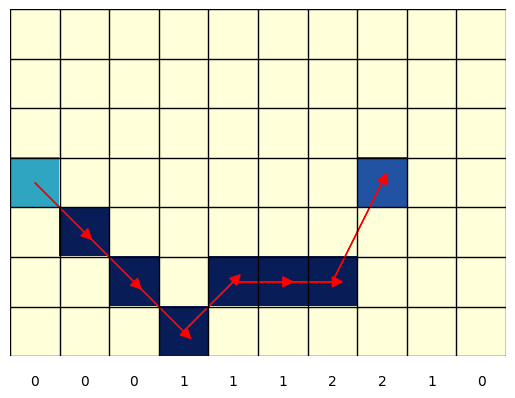

Total Reward: -6


In [82]:
env.render(mode='agent', q_table=q_learning_q_table)

> **Inferences (Q-Learning)**

* The best parameter for Q-Learning is (alpha, gamma): (0.3, 0.95).
* Q-learning converge within 200 episodes, as lower episodes will not output the best path.
* The best reward is -6, which means it took minimum of 6 steps to reach the goal state.

**N-Step SARSA**

> **Hyperparameter Selection (N-Step SARSA)**

|Hyperparameter|Selection|Explanation|
|:-:|:--|:--|
|N|[5, 7]|Number of steps|
|Epsilon|[0.1, 0.2]|- Parameters for epsilon greedy.<br>- Epsilon is the probability of choosing to explore |
|Alpha|[0.1, 0.2, 0.3]|Learning Rate|
|Gamma|[0.9, 1]|- Discount Factor<br>- It is advised to be closer to 1|

In [96]:
# Parameter to tune
ns = [5, 7]
epsilons = [0.1, 0.2]
alphas = [0.1, 0.2, 0.3]
gammas = [0.9, 1]


num_episodes = 2000
results = {}
rewards = {}
step_ep_lists = {}

for epsilon in epsilons:
    for alpha in alphas:
        for gamma in gammas:
            for n in ns:
                env = WindyGridWorldEnvKingsMove()
                q_table, episode_rewards, episode_steps = n_step_sarsa(env, num_episodes, n=n, alpha=alpha, gamma=gamma, epsilon=epsilon)
                results[(alpha, epsilon, gamma, n)] = q_table
                rewards[(alpha, epsilon, gamma, n)] = episode_rewards
                step_ep_lists[(alpha, epsilon, gamma, n)] = episode_steps

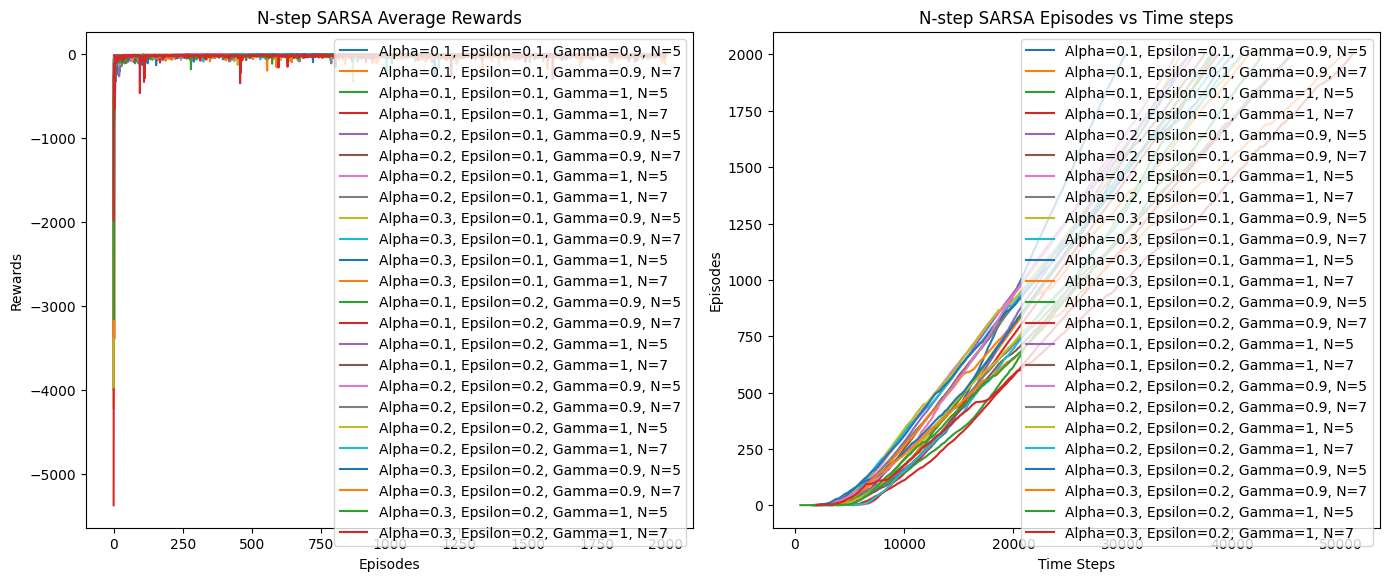

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Average Rewards
for (alpha, epsilon, gamma, n), reward in rewards.items():
    axs[0].plot(range(len(reward)), reward, label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}, N={n}")

axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Rewards")
axs[0].set_title('N-step SARSA Average Rewards', fontsize='large')
axs[0].legend()

# Plotting Episodes vs Time steps
for (alpha, epsilon, gamma, n), step_ep_list in step_ep_lists.items():
    axs[1].plot(np.cumsum(step_ep_list), range(1, num_episodes + 1), label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}, N={n}")

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Episodes")
axs[1].set_title('N-step SARSA Episodes vs Time steps', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

In [98]:
windy_n_step_sarsa_best_parameter = None
best_reward = float('-inf')

for n in ns:
    for alpha in alphas:
        for epsilon in epsilons:
            for gamma in gammas:
                reward = np.sum(rewards[(alpha, epsilon, gamma, n)])
                if reward > best_reward:
                    best_reward = reward
                    windy_n_step_sarsa_best_parameter = (alpha, epsilon, gamma, n)

print("Best Parameter Combination (alpha, epsilon, gamma, n):", windy_n_step_sarsa_best_parameter)

Best Parameter Combination (alpha, epsilon, gamma, n): (0.1, 0.1, 0.9, 5)


In [121]:
# Define parameters
num_episodes = 900
alpha = windy_n_step_sarsa_best_parameter[0]
epsilon = windy_n_step_sarsa_best_parameter[1]
gamma = windy_n_step_sarsa_best_parameter[2]
n = windy_n_step_sarsa_best_parameter[3]

start = time.time()

env = WindyGridWorldEnvKingsMove()
n_step_sarsa_q_table, n_step_sarsa_episode_rewards, n_step_sarsa_episode_steps = n_step_sarsa(env, num_episodes,n , alpha, gamma, epsilon)

end = time.time()
total_time = end - start
print("\nTotal Runtime for N-Step SARSA:", str(total_time), "second")


Total Runtime for N-Step SARSA: 0.5779056549072266 second


Rendering Agent Mode


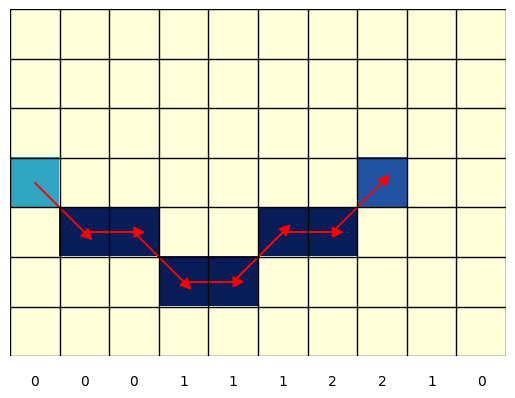

Total Reward: -6


In [122]:
env.render(mode='agent', q_table=n_step_sarsa_q_table)

> **Inferences (N-step SARSA)**

* The best parameter for N-step SARSA is (alpha, gamma, episilon, n): (0.1, 1, 0.1, 5). **(Note that the best parameters might differ on a few runtime)**
* N-step SARSA converge within 400 episodes, as lower episodes will not output the best path.
* It converges slower than SARSA, due to N-step SARSA considering multiple steps into the future, which can introduce additional variance and noise causing the algorithm be unable to capture long-term dependency in the data resulting in poor choice of pathing.
* The best reward is -6, which means it took minimum of 6 steps to reach the goal state.

**Comparison on TD Learning Methods**<br><br>

In [123]:
step_ep_lists = {}
rewards = {}

env = WindyGridWorldEnvKingsMove()

# Define parameters
num_episodes = 2000
alpha = windy_sarsa_best_parameter[0]
epsilon = windy_sarsa_best_parameter[1]
gamma = windy_sarsa_best_parameter[2]

method = 'sarsa'
sarsa_q_table, sarsa_episode_rewards, sarsa_episode_steps = sarsa(env, num_episodes, alpha, gamma, epsilon)
step_ep_lists[method] = sarsa_episode_steps
rewards[method] = sarsa_episode_rewards

alpha = windy_expected_sarsa_best_parameter[0]
epsilon = windy_expected_sarsa_best_parameter[1]
gamma = windy_expected_sarsa_best_parameter[2]

method = 'expected_sarsa'
expected_sarsa_q_table, expected_sarsa_episode_rewards, expected_sarsa_episode_steps = expected_sarsa(env, num_episodes, alpha, gamma, epsilon)
step_ep_lists[method] = expected_sarsa_episode_steps
rewards[method] = expected_sarsa_episode_rewards

alpha = windy_q_learning_best_parameter[0]
gamma = windy_q_learning_best_parameter[1]

method = 'q-learning'
q_learning_agent = QLearningAgent(env, learning_rate=alpha, discount_factor=gamma)
q_learning_q_table, q_learning_episode_rewards, q_learning_episode_steps = q_learning_agent.train(num_episodes)
step_ep_lists[method] = q_learning_episode_steps
rewards[method] = q_learning_episode_rewards

alpha = windy_n_step_sarsa_best_parameter[0]
epsilon = windy_n_step_sarsa_best_parameter[1]
gamma = windy_n_step_sarsa_best_parameter[2]
n = windy_n_step_sarsa_best_parameter[3]

method = 'n_step_sarsa'
n_step_sarsa_q_table, n_step_sarsa_episode_rewards, n_step_sarsa_episode_steps = n_step_sarsa(env, num_episodes,n , alpha, gamma, epsilon)
step_ep_lists[method] = n_step_sarsa_episode_steps
rewards[method] = n_step_sarsa_episode_rewards



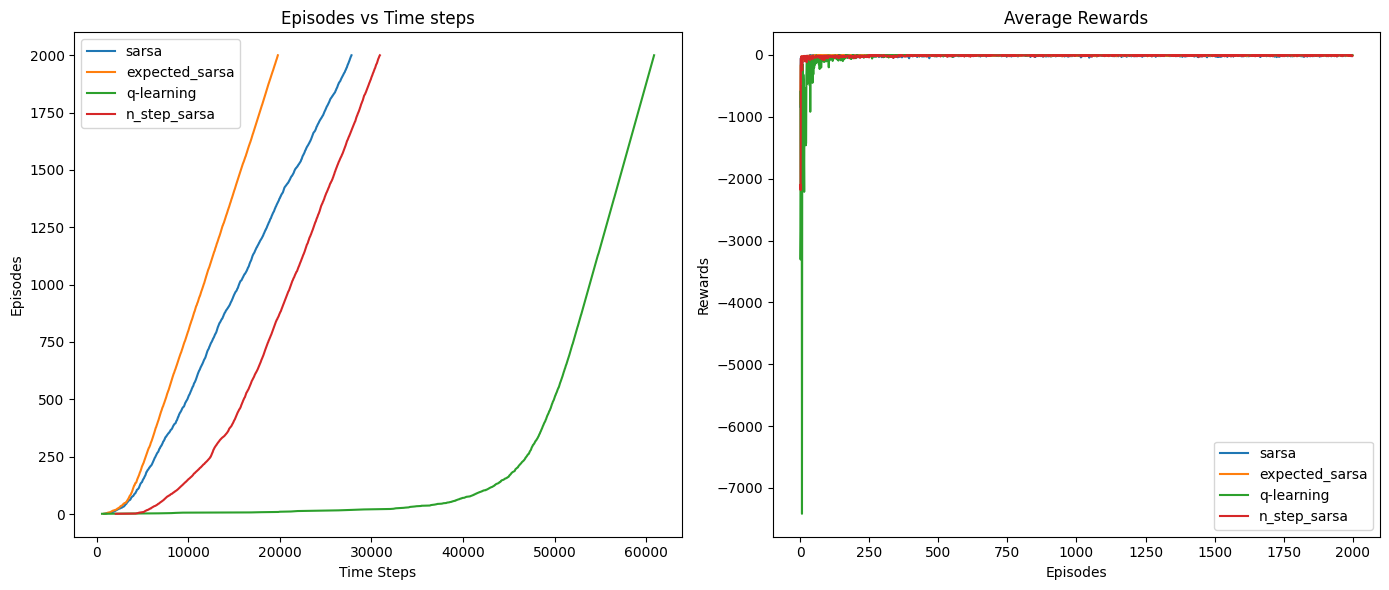

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plotting Episodes vs Time steps
for method, step_ep_list in step_ep_lists.items():
    axs[0].plot(np.cumsum(step_ep_list), range(1, num_episodes + 1), label=f"{method}")
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("Episodes")
axs[0].set_title('Episodes vs Time steps', fontsize='large')
axs[0].legend()


# Rewards vs episodes
for method, reward in rewards.items():
    axs[1].plot(range(len(reward)), reward, label=f"{method}")

axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Rewards")
axs[1].set_title('Average Rewards', fontsize='large')
axs[1].legend()
plt.tight_layout()
plt.show()

> **Inferences (All Temporal Difference methods)**
* Q-learning required more episodes to converge compared to SARSA, Expected SARSA, and n-step SARSA.
* This is because Q-learning is an off-policy algorithm, which it updates its Q-values based on the maximum estimated future rewards, regardless of the policy being followed. In contrast, the other 3 TD Methods are on-policy methods, which update Q-values based on the policy being followed duuting exploration.
* Off-policy methods tend to be more conservative and may require longer to converge as they are updating values based on a policy that the agent is not actively following.
* Based on the graph, we can observe Q-learning has the most negative rewards compared with the other methods
* Q-learning explores the environment more, therefore resulting in a high negative rewards in the first 200 episodes.
* SARSA recorded fewer runtime, as it require less computational cost than Expected SARSA
* Expected SARSA converged in fewer episodes.
* Based on the graph, we oberved that Expected SARSA performed more stable than SARSA and N-step SARSA, as it has smaller standard deviation between different runs/ episodes.
* This is in line with our hypothesis, where Sarsa more often samples noisy actions to update its Q values, while expected Sarsa always considers all possible actions when updating values, which eliminates variance and causes much more stable results.
* All Temporal Difference method gave us same best rewards (-6), but Expected SARSA needs fewer episodes to converge.

#### Monte Carlo Tree Search

reward_e -167
reward_e -33
reward_e -61
reward_e -69
reward_e -41
reward_e -301
reward_e -71
reward_e -162
reward_e -311
reward_e -28

Total Runtime for MCTS: 66.92324018478394 second
Rendering Agent Mode


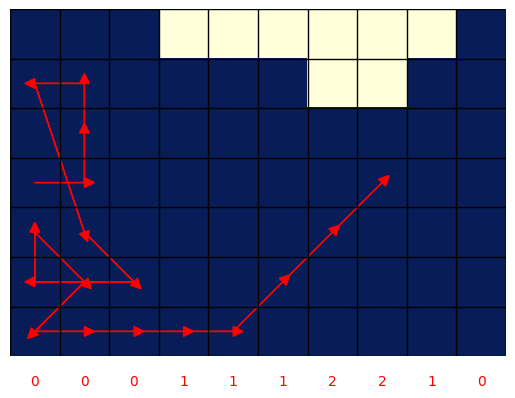

In [125]:
best_reward = -math.inf
episodes = 10
average_values = []
'''
Here we are experimenting with our implementation:
- we play a certain number of episodes of the game
- for deciding each move to play at each step, we will apply our MCTS algorithm
- we will collect and plot the rewards to check if the MCTS is actually working.
'''

for e in range(episodes):
    iterations = 0
    start = time.time()
    path = [(3,0)]
    reward_e = 0
    game = WindyGridWorldEnvKingsMove()
    observation = game.reset()
    done = False

    new_game = deepcopy(game)
    mytree = Node(new_game, False, 0, observation, 0)

    while not done:
        mytree, action = Policy_Player_MCTS(mytree)

        observation, reward, done, _ = game.step(action)

        reward_e = reward_e + reward

        if observation not in path:
            path.append(observation)

        if done:
            print('reward_e ' + str(reward_e))
            game.close()
            break

    end = time.time()

    if reward_e > best_reward:
        best_reward = reward_e
        best_path = path
        best_time = end - start

print("\nTotal Runtime for MCTS:", str(best_time), "second")
game.render('without_q_table', False, None, best_path)

**Inference for MCTS**

The MCTS is runned for 10 episodes to get the episode with best rewards. Then, the optimal path walked in that episode is shown. The rewards is very low for this algorithm. It needs much time for about 66.92324018478394 seconds to reach the goal state.

#### Stochastic Windy Grid World with King's Move

#### Dynamic Programming

**Policy Iteration**

In [126]:
env = StochasticWindyGridWorldEnvKingsMove()

env.reset()
env.render()
#env.close()

print(env.observation_space)

print(env.action_space)

discount_rate = 0.9

no_states = 70

no_actions = 8

no_iterations = 1000

v_state_initial = np.zeros(70)
initial_policy=(1/no_actions)*np.ones((no_states,no_actions))

convergence_tol = 10**(-6)

Rendering Human Mode
Tuple(Discrete(7), Discrete(10))
Discrete(8)


In [127]:
env.P = create_stochastic_king_env_P(env)

In [128]:
value_function_policy_iter = []
current_policy = initial_policy

start = time.time()

for iter in range(no_iterations):
    q_matrix = {}
    print("Iteration - {} - of policy iteration algorithm".format(iter))

    v_state = policy_evaluation(env,v_state_initial,current_policy,discount_rate,no_iterations,convergence_tol)
    #print(v_state)

    value_function_policy_iter.append(v_state)

    improved_policy,q_matrix = policy_improvement(env,v_state,no_actions,no_states,discount_rate, q_matrix)

    if np.allclose(current_policy,improved_policy):
        current_policy = improved_policy
        print("\nPolicy iteration algorithm converged!")
        break
    current_policy = improved_policy

end = time.time()
total_time = end - start
print("\nTotal Runtime for Policy Iteration:", str(total_time), "second")

Iteration - 0 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 1 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 2 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 3 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 4 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 5 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!
Iteration - 6 - of policy iteration algorithm
Itarative Policy Evaluation Converged!!!

Policy iteration algorithm converged!

Total Runtime for Policy Iteration: 0.5417978763580322 second


The policy iteration algorithm converged in iteration 7.

Rendering Agent Mode


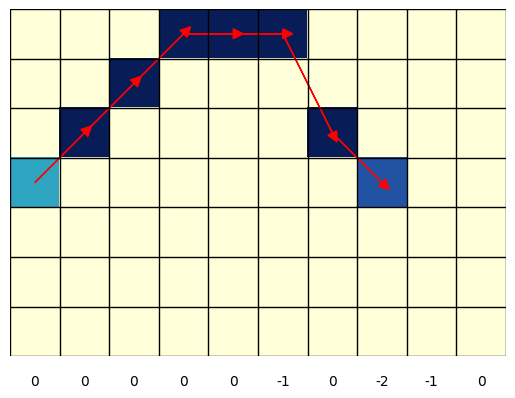

Total Reward: -6


In [129]:
env = StochasticWindyGridWorldEnvKingsMove()
env.render(mode='agent', q_table=q_matrix)

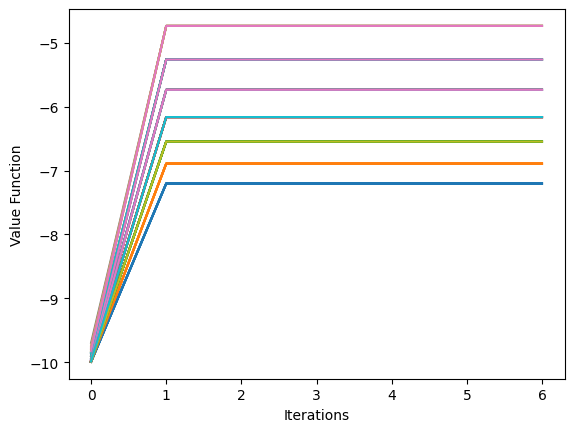

In [130]:
plt.plot(value_function_policy_iter)
plt.xlabel('Iterations')
plt.ylabel('Value Function')
plt.show()

The graph above shows that the value function increases rapidly in first 2 iterations, then becomes gently and converged in iteration 4.

**Value Iteration**

In [131]:
env.P = create_stochastic_king_env_P(env)

start = time.time()

v_state, v_value_iter= value_iteration(env,v_state_initial,discount_rate,no_iterations,convergence_tol)

end = time.time()
total_time = end - start
print("\nTotal Runtime for Value Iteration:", str(total_time), "second")

Value Iteration Converged at Iteration 132 !!!

Value State Function:
 [-7.20293779 -6.89215401 -6.54683779 -6.16315401 -5.73683779 -5.26315401
 -5.26315401 -4.73683779 -5.26315401 -5.26315401 -7.20293779 -6.89215401
 -6.54683779 -6.16315401 -5.73683779 -5.26315401 -5.26315401 -5.26315401
 -4.73683779 -5.26315401 -7.20293779 -6.89215401 -6.54683779 -6.16315401
 -5.73683779 -5.26315401 -4.73683779 -4.73683779 -4.73683779 -5.26315401
 -7.20293779 -6.89215401 -6.54683779 -6.16315401 -5.73683779 -5.26315401
 -4.73683779 -5.26315401 -4.73683779 -5.26315401 -7.20293779 -6.89215401
 -6.54683779 -6.16315401 -5.73683779 -5.26315401 -4.73683779 -5.73683779
 -5.73683779 -5.26315401 -7.20293779 -6.89215401 -6.54683779 -6.16315401
 -5.73683779 -5.73683779 -5.26315401 -6.16315401 -6.16315401 -5.73683779
 -7.20293779 -6.89215401 -6.54683779 -6.16315401 -6.16315401 -6.16315401
 -5.73683779 -6.16315401 -6.54683779 -6.16315401]

Total Runtime for Value Iteration: 0.05664253234863281 second


The value iteration algorithm converged in iteration 132. Above shows the optimal value function.

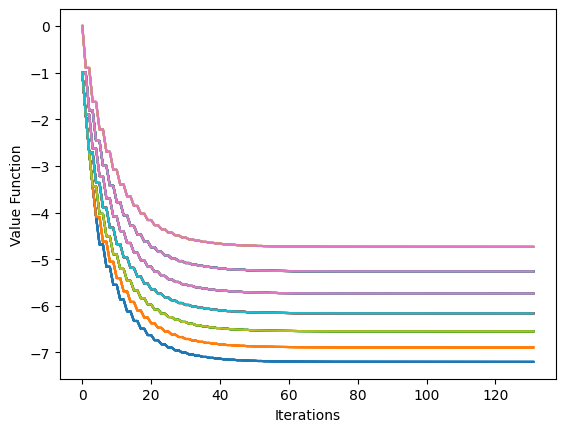

In [132]:
plt.plot(v_value_iter)
plt.xlabel('Iterations')
plt.ylabel('Value Function')
plt.show()

Above graph visualizes the value iteration algorithm which converged at iteration 132. The value function decrease rapidly in first 20 iterations. Then it decreases gently in following iterations and converged in iteration 132.

#### Monte Carlo Control

**First Visit On Policy**

In [133]:
num_episodes = 20000
alphas = [0.005, 0.01, 0.1]

results = {}

# Grid Search Hyperparameter Tuning
for alpha in alphas:
    env = StochasticWindyGridWorldEnvKingsMove()
    print("\nNow running alpha:", alpha)
    _, _, episode_rewards = firstVisitOnPolicy(env, num_episodes, alpha=alpha)
    results[alpha] = episode_rewards


Now running alpha: 0.005
Episode 20000/20000.
Now running alpha: 0.01
Episode 20000/20000.
Now running alpha: 0.1
Episode 20000/20000.

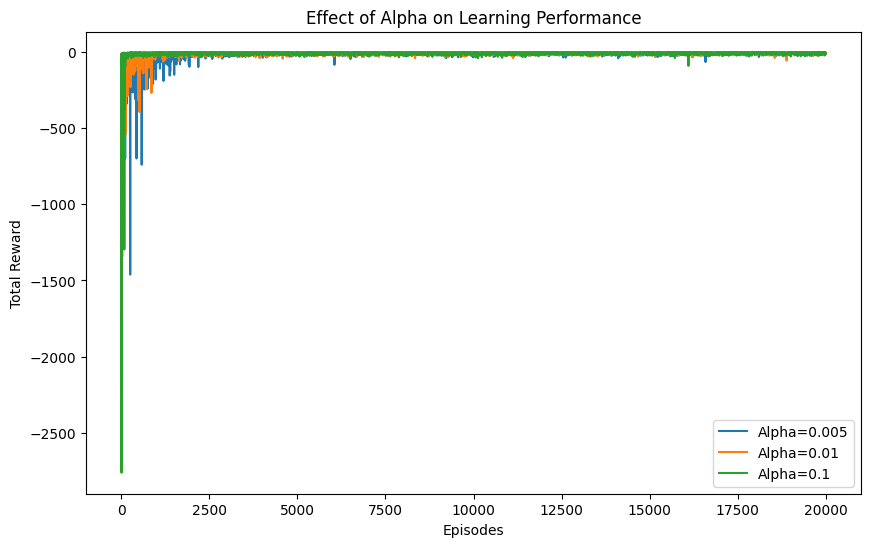

In [134]:
# Plot a graph for step_ep_list for all parameter combinations
plt.figure(figsize=(10, 6))
for alpha, reward in results.items():
    plt.plot(range(len(reward)), reward, label=f"Alpha={alpha}")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title('Effect of Alpha on Learning Performance')
plt.legend()
plt.show()

In [135]:
stochastic_mc_best_parameter = None
best_reward = float('-inf')

for alpha in alphas:
    reward = np.sum(results[alpha])
    if reward > best_reward:
        best_reward = reward
        stochastic_mc_best_parameter = alpha

print("Best Alpha:", stochastic_mc_best_parameter)

Best Alpha: 0.1


In [32]:
# obtain the estimated optimal policy and action-value function
start = time.time()

env = StochasticWindyGridWorldEnvKingsMove()
policy, Q, _ = firstVisitOnPolicy(env, 20000, alpha=stochastic_mc_best_parameter)

end = time.time()
total_time = end - start
print("\nTotal Runtime for Monte Carlo First Visit:", str(total_time), "second")

Episode 20000/20000.
Total Runtime for Monte Carlo First Visit: 32.114784479141235 second


Rendering Agent Mode


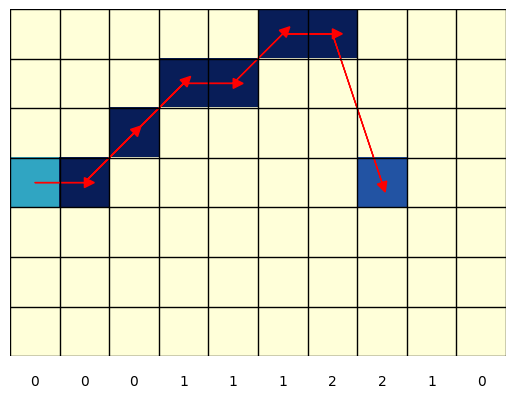

Total Reward: -6


In [33]:
env.render(mode='agent', q_table = Q)

#### Temporal Difference Learning

**SARSA (0)**

> **Hyperparameter Selection (SARSA)**

|Hyperparameter|Selection|Explanation|
|:-:|:--|:--|
|Epsilon|[0.1, 0.2]|- Parameters for epsilon greedy.<br>- Epsilon is the probability of choosing to explore |
|Alpha|[0.4, 0.5, 0.6]|Learning Rate|
|Gamma|[0.9, 1]|- Discount Factor<br>- It is advised to be closer to 1|

In [136]:
# Parameter to tune
epsilons = [0.1, 0.2]
alphas = [0.4, 0.5, 0.6]
gammas = [0.9, 1]

num_episodes=2000
results = {}
rewards = {}
step_ep_lists = {}

# Grid Search Hyperparameter Tuning
for epsilon in epsilons:
    for alpha in alphas:
        for gamma in gammas:
            env = StochasticWindyGridWorldEnvKingsMove()
            q_table, episode_rewards, episode_steps = sarsa(env, num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)
            results[(alpha, epsilon, gamma)] = q_table
            rewards[(alpha, epsilon, gamma)] = episode_rewards
            step_ep_lists[(alpha, epsilon, gamma)] = episode_steps

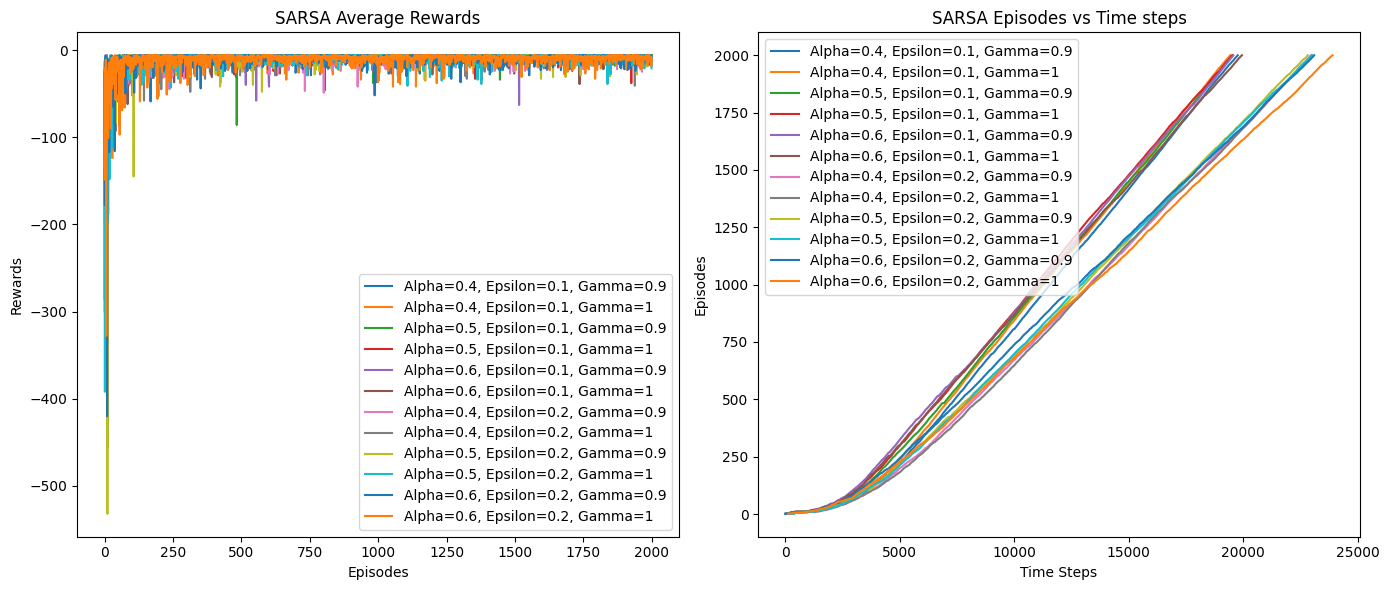

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for (alpha, epsilon, gamma), reward in rewards.items():
    axs[0].plot(range(len(reward)), reward, label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}")

axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Rewards")
axs[0].set_title('SARSA Average Rewards', fontsize='large')
axs[0].legend()

# Plotting Episodes vs Time steps
for (alpha, epsilon, gamma), step_ep_list in step_ep_lists.items():
    axs[1].plot(np.cumsum(step_ep_list), range(1, num_episodes + 1), label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}")

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Episodes")
axs[1].set_title('SARSA Episodes vs Time steps', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

In [138]:
stochastic_sarsa_best_parameter = None
best_reward = float('-inf')

for alpha in alphas:
    for epsilon in epsilons:
        for gamma in gammas:
            reward = np.sum(rewards[(alpha, epsilon, gamma)])
            if reward > best_reward:
                best_reward = reward
                stochastic_sarsa_best_parameter = (alpha, epsilon, gamma)

print("Best Parameter Combination (alpha, epsilon, gamma):", stochastic_sarsa_best_parameter)

Best Parameter Combination (alpha, epsilon, gamma): (0.4, 0.1, 1)


In [139]:
# Define parameters
num_episodes = 300
alpha = stochastic_sarsa_best_parameter[0]
epsilon = stochastic_sarsa_best_parameter[1]
gamma = stochastic_sarsa_best_parameter[2]

start = time.time()

env = StochasticWindyGridWorldEnvKingsMove()
sarsa_q_table, sarsa_episode_rewards, sarsa_episode_steps = sarsa(env, num_episodes, alpha, gamma, epsilon)

end = time.time()
total_time = end - start
print("\nTotal Runtime for SARSA(0):", str(total_time), "second")


Total Runtime for SARSA(0): 0.10118865966796875 second


Rendering Agent Mode


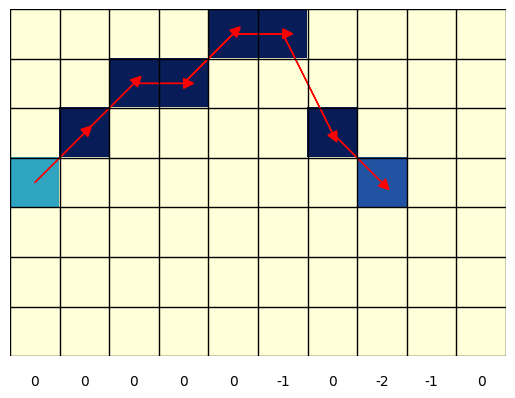

Total Reward: -6


In [140]:
env.render(mode='agent', q_table=sarsa_q_table)

> **Inferences (SARSA)**

* The best parameter for SARSA is (alpha, epsilon, gamma): (0.6, 0.1, 0.9).
* SARSA converges within 300 episodes to consistenly get best reward.
* The best reward for SARSA is -6, which means it took minimum of 6 steps to reach the goal state.

**Expected SARSA**

> **Hyperparameter Selection (Expected SARSA)**

|Hyperparameter|Selection|Explanation|
|:-:|:--|:--|
|Epsilon|[0.1, 0.2]|- Parameters for epsilon greedy.<br>- Epsilon is the probability of choosing to explore |
|Alpha|[0.8, 0.9, 1.0]|Learning Rate|
|Gamma|[0.9, 1]|- Discount Factor<br>- It is advised to be closer to 1|

In [141]:
# Parameter to tune
epsilons = [0.1, 0.2]
alphas = [0.8, 0.9, 1.0]
gammas = [0.9, 1]

num_episodes=200
results = {}
rewards = {}
step_ep_lists = {}

# Grid Search Hyperparameter Tuning
for epsilon in epsilons:
    for alpha in alphas:
        for gamma in gammas:
            env = StochasticWindyGridWorldEnvKingsMove()
            q_table, episode_rewards, episode_steps = expected_sarsa(env, num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)
            results[(alpha, epsilon, gamma)] = q_table
            rewards[(alpha, epsilon, gamma)] = episode_rewards
            step_ep_lists[(alpha, epsilon, gamma)] = episode_steps

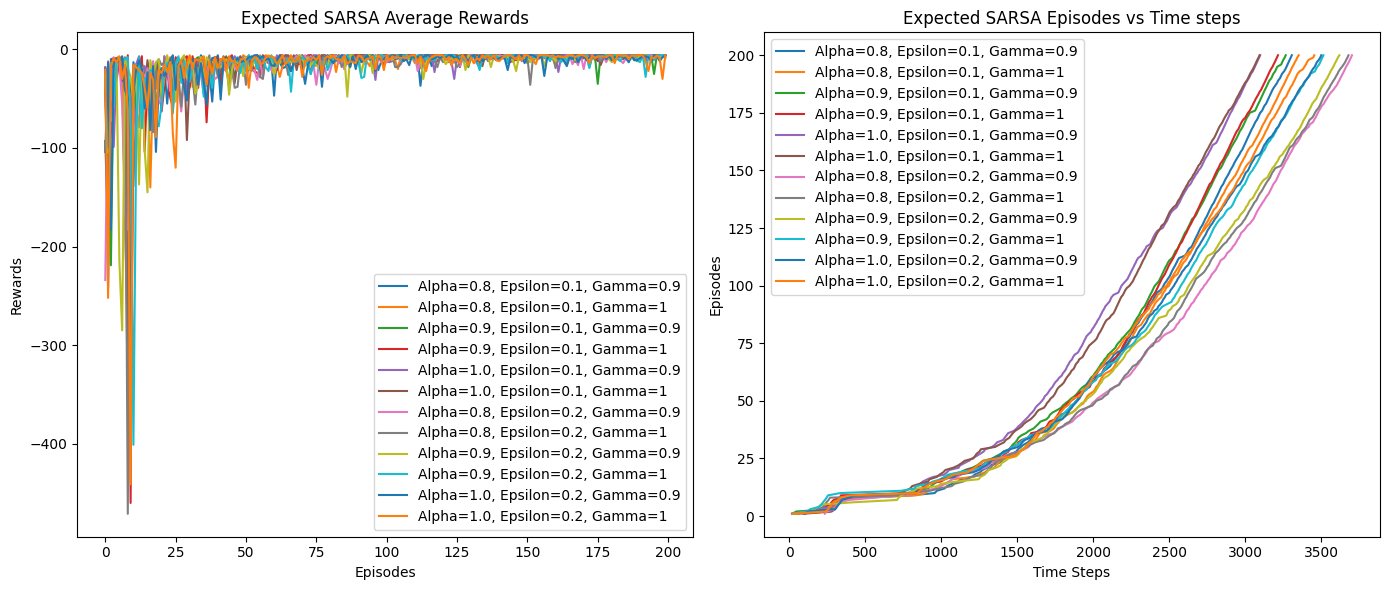

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for (alpha, epsilon, gamma), reward in rewards.items():
    axs[0].plot(range(len(reward)), reward, label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}")

axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Rewards")
axs[0].set_title('Expected SARSA Average Rewards', fontsize='large')
axs[0].legend()

# Plotting Episodes vs Time steps
for (alpha, epsilon, gamma), step_ep_list in step_ep_lists.items():
    axs[1].plot(np.cumsum(step_ep_list), range(1, num_episodes + 1), label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}")

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Episodes")
axs[1].set_title('Expected SARSA Episodes vs Time steps', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

In [143]:
stochastic_expected_sarsa_best_parameter = None
best_reward = float('-inf')

for alpha in alphas:
    for epsilon in epsilons:
        for gamma in gammas:
            reward = np.sum(rewards[(alpha, epsilon, gamma)])
            if reward > best_reward:
                best_reward = reward
                stochastic_expected_sarsa_best_parameter = (alpha, epsilon, gamma)

print("Best Parameter Combination (alpha, epsilon, gamma):", stochastic_expected_sarsa_best_parameter)

Best Parameter Combination (alpha, epsilon, gamma): (1.0, 0.1, 1)


In [144]:
# Define parameters
num_episodes = 150
alpha = stochastic_expected_sarsa_best_parameter[0]
epsilon = stochastic_expected_sarsa_best_parameter[1]
gamma = stochastic_expected_sarsa_best_parameter[2]

start = time.time()

env = StochasticWindyGridWorldEnvKingsMove()
expected_sarsa_q_table, expected_sarsa_episode_rewards, expected_sarsa_episode_steps = expected_sarsa(env, num_episodes, alpha, gamma, epsilon)

end = time.time()
total_time = end - start
print("\nTotal Runtime for Expected SARSA:", str(total_time), "second")


Total Runtime for Expected SARSA: 0.13307905197143555 second


Rendering Agent Mode


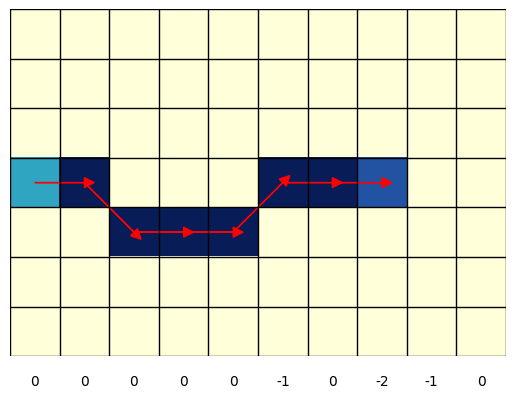

Total Reward: -6


In [145]:
env.render(mode='agent', q_table=expected_sarsa_q_table)

> **Inferences (Expected SARSA)**

* The best parameter for Expected SARSA is (alpha, epsilon, gamma): (1.0, 0.1, 0.9).
* The best alpha is 1.0, which is quite a surprise, as it indicates that Expected SARSA in Stochastic Windy Grid World benefits from a full replacement of the Q value with the new estimate during the learning process.
* However, according to [A Theoretical and Empirical Analysis of Expected Sarsa](https://www.cs.ox.ac.uk/people/shimon.whiteson/pubs/vanseijenadprl09.pdf), it stated that Expected SARSA can employ alpha of 1, as Expected SARSA has low variance, and lower variance means that in practice alpha can often be increased in order to speed learning.
* Expected SARSA converges within 150 episodes to consistenly get best reward.
* The best reward for SARSA is -6, which means it took minimum of 6 steps to reach the goal state.

**Q-Learning**

> **Hyperparameter Selection (Q-Learning)**

|Hyperparameter|Selection|Explanation|
|:-:|:--|:--|
|Alpha|[0.1, 0.2, 0.3]|Learning Rate|
|Gamma|[0.9, 0.95, 1]|- Discount Factor<br>- It is advised to be closer to 1|

In [146]:
# Create WindyGridWorldEnvKingsMove environment
env = StochasticWindyGridWorldEnvKingsMove()

# Parameter grid for learning rate and discount factor
alphas = [0.1, 0.2, 0.3]
gammas = [0.9, 0.95, 1.0]

# Perform Q-learning grid search
results, rewards, steps_counts = q_learning_grid_search(env, alphas, gammas, num_episodes=200)

# Visualize the learned path for the best set of hyperparameters
best_alpha, best_gamma = max(results, key=lambda key: np.mean(rewards[key]))
best_q_table = results[(best_alpha, best_gamma)]
best_agent = QLearningAgent(env, learning_rate=best_alpha, discount_factor=best_gamma)
best_agent.q_table = best_q_table

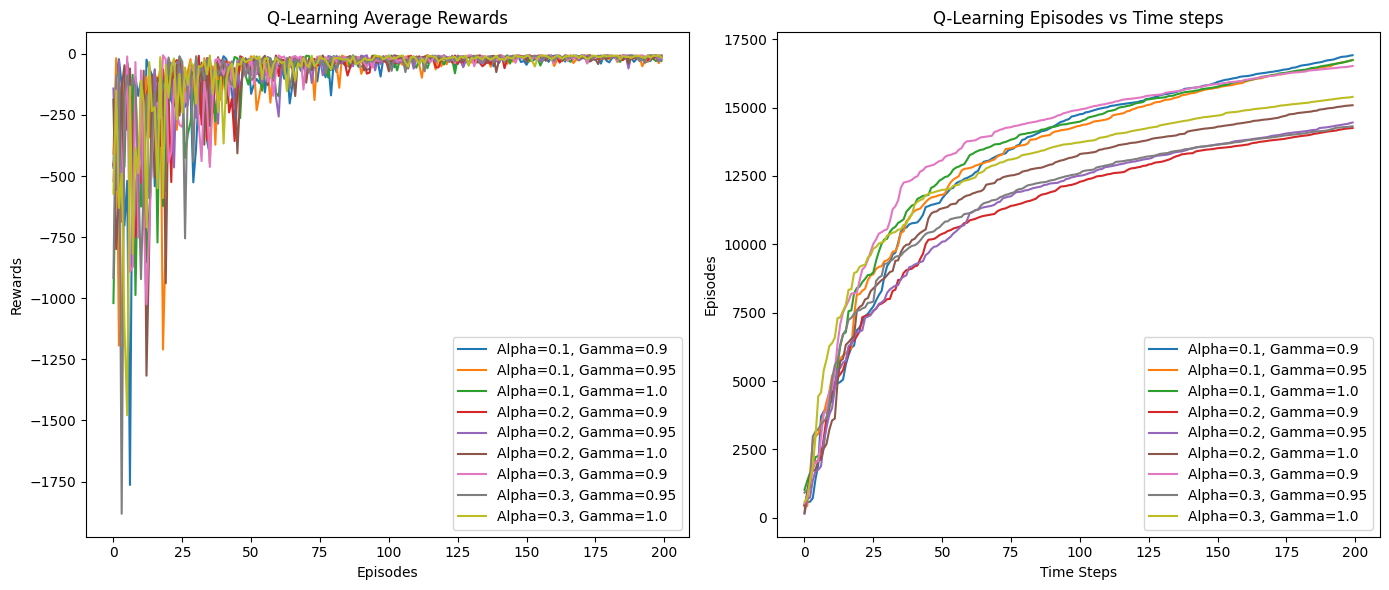

In [147]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for (alpha, gamma), reward in rewards.items():
    axs[0].plot(range(len(reward)), reward, label=f"Alpha={alpha}, Gamma={gamma}")

axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Rewards")
axs[0].set_title('Q-Learning Average Rewards', fontsize='large')
axs[0].legend()

# Plotting Episodes vs Time steps
for (alpha, gamma), steps in steps_counts.items():
    axs[1].plot(np.cumsum(steps), label=f"Alpha={alpha}, Gamma={gamma}")

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Episodes")
axs[1].set_title('Q-Learning Episodes vs Time steps', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

In [148]:
stochastic_q_learning_best_parameter = None
best_reward = float('-inf')

for alpha in alphas:
    for gamma in gammas:
        reward = np.sum(rewards[(alpha, gamma)])
        if reward > best_reward:
            best_reward = reward
            stochastic_q_learning_best_parameter = (alpha, gamma)

print("Best Parameter Combination (alpha, gamma):", stochastic_q_learning_best_parameter)

Best Parameter Combination (alpha, gamma): (0.2, 0.9)


In [149]:
# Define parameters
num_episodes = 800
alpha = stochastic_q_learning_best_parameter[0]
gamma = stochastic_q_learning_best_parameter[1]

start = time.time()

env = StochasticWindyGridWorldEnvKingsMove()
q_learning_agent = QLearningAgent(env, learning_rate=alpha, discount_factor=gamma)
q_learning_q_table, q_learning_episode_rewards, q_learning_episode_steps = q_learning_agent.train(num_episodes)

end = time.time()
total_time = end - start
print("\nTotal Runtime for Q-Learning:", str(total_time), "second")


Total Runtime for Q-Learning: 0.607276201248169 second


Rendering Agent Mode


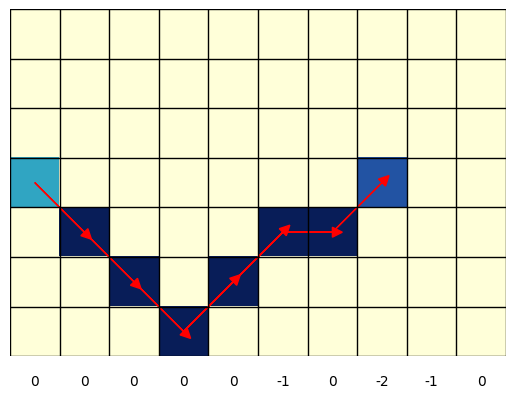

Total Reward: -6


In [150]:
env.render(mode='agent', q_table=q_learning_q_table)

> **Inferences (Q-learning)**

* The best parameter for Q-learning is (alpha, gamma): (0.3, 0.9).
* Q-learning converges within 300 episodes to consistenly get best reward.
* The best reward for Q-learning is -6, which means it took minimum of 6 steps to reach the goal state.

**N-step SARSA**

> **Hyperparameter Selection (N-Step SARSA)**

|Hyperparameter|Selection|Explanation|
|:-:|:--|:--|
|N|[5, 7]|Number of steps|
|Epsilon|[0.1, 0.2]|- Parameters for epsilon greedy.<br>- Epsilon is the probability of choosing to explore |
|Alpha|[0.1, 0.2, 0.3]|Learning Rate|
|Gamma|[0.9, 1]|- Discount Factor<br>- It is advised to be closer to 1|

In [151]:
# Parameter to tune
ns = [5, 7]
epsilons = [0.1, 0.2]
alphas = [0.1, 0.2, 0.3]
gammas = [0.9, 1]


num_episodes = 2000
results = {}
rewards = {}
step_ep_lists = {}

for epsilon in epsilons:
    for alpha in alphas:
        for gamma in gammas:
            for n in ns:
                env = StochasticWindyGridWorldEnvKingsMove()
                q_table, episode_rewards, episode_steps = n_step_sarsa(env, num_episodes, n=n, alpha=alpha, gamma=gamma, epsilon=epsilon)
                results[(alpha, epsilon, gamma, n)] = q_table
                rewards[(alpha, epsilon, gamma, n)] = episode_rewards
                step_ep_lists[(alpha, epsilon, gamma, n)] = episode_steps

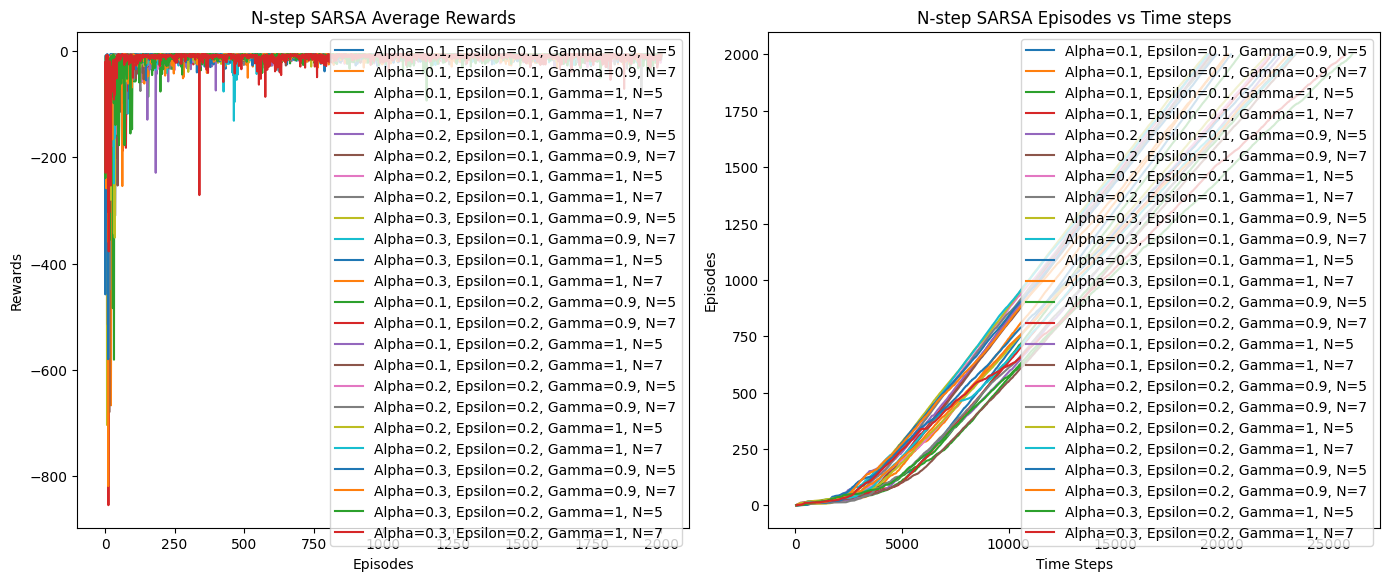

In [152]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Average Rewards
for (alpha, epsilon, gamma, n), reward in rewards.items():
    axs[0].plot(range(len(reward)), reward, label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}, N={n}")

axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Rewards")
axs[0].set_title('N-step SARSA Average Rewards', fontsize='large')
axs[0].legend()

# Plotting Episodes vs Time steps
for (alpha, epsilon, gamma, n), step_ep_list in step_ep_lists.items():
    axs[1].plot(np.cumsum(step_ep_list), range(1, num_episodes + 1), label=f"Alpha={alpha}, Epsilon={epsilon}, Gamma={gamma}, N={n}")

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Episodes")
axs[1].set_title('N-step SARSA Episodes vs Time steps', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

In [153]:
stochastic_n_step_sarsa_best_parameter = None
best_reward = float('-inf')

for n in ns:
    for alpha in alphas:
        for epsilon in epsilons:
            for gamma in gammas:
                reward = np.sum(rewards[(alpha, epsilon, gamma, n)])
                if reward > best_reward:
                    best_reward = reward
                    stochastic_n_step_sarsa_best_parameter = (alpha, epsilon, gamma, n)

print("Best Parameter Combination (alpha, epsilon, gamma, n):", stochastic_n_step_sarsa_best_parameter)

Best Parameter Combination (alpha, epsilon, gamma, n): (0.3, 0.1, 0.9, 5)


In [154]:
# Define parameters
num_episodes = 900
alpha = stochastic_n_step_sarsa_best_parameter[0]
epsilon = stochastic_n_step_sarsa_best_parameter[1]
gamma = stochastic_n_step_sarsa_best_parameter[2]
n = stochastic_n_step_sarsa_best_parameter[3]

start = time.time()

env = StochasticWindyGridWorldEnvKingsMove()
n_step_sarsa_q_table, n_step_sarsa_episode_rewards, n_step_sarsa_episode_steps = n_step_sarsa(env, num_episodes,n , alpha, gamma, epsilon)

end = time.time()
total_time = end - start
print("\nTotal Runtime for N-Step SARSA:", str(total_time), "second")


Total Runtime for N-Step SARSA: 0.2911510467529297 second


Rendering Agent Mode


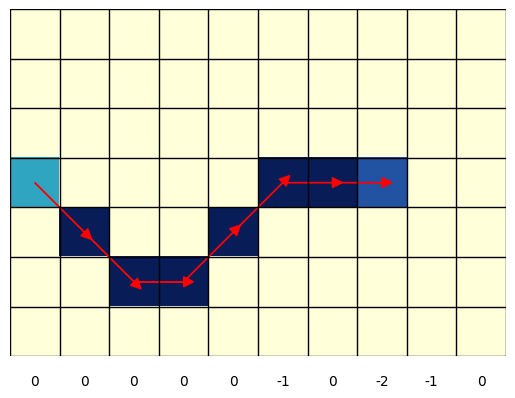

Total Reward: -6


In [155]:
env.render(mode='agent', q_table=n_step_sarsa_q_table)

> **Inferences (N-step SARSA)**

* The best parameter for N-step SARSA is (alpha, gamma, episilon, n): (0.2, 1, 0.1, 5).
* N-step SARSA converge within 300 episodes, as lower episodes will not output the best path.
* It converges slower than SARSA, due to N-step SARSA considering multiple steps into the future, which can introduce additional variance and noise causing the algorithm be unable to capture long-term dependency in the data resulting in poor choice of pathing.
* The best reward is -6, which means it took minimum of 6 steps to reach the goal state.

**Comparison between Different TD Learning Methods**

In [156]:
step_ep_lists = {}
rewards = {}

env = StochasticWindyGridWorldEnvKingsMove()

# Define parameters
num_episodes = 2000
alpha = stochastic_sarsa_best_parameter[0]
epsilon = stochastic_sarsa_best_parameter[1]
gamma = stochastic_sarsa_best_parameter[2]

method = 'sarsa'
sarsa_q_table, sarsa_episode_rewards, sarsa_episode_steps = sarsa(env, num_episodes, alpha, gamma, epsilon)
step_ep_lists[method] = sarsa_episode_steps
rewards[method] = sarsa_episode_rewards

alpha = stochastic_expected_sarsa_best_parameter[0]
epsilon = stochastic_expected_sarsa_best_parameter[1]
gamma = stochastic_expected_sarsa_best_parameter[2]

method = 'expected_sarsa'
expected_sarsa_q_table, expected_sarsa_episode_rewards, expected_sarsa_episode_steps = expected_sarsa(env, num_episodes, alpha, gamma, epsilon)
step_ep_lists[method] = expected_sarsa_episode_steps
rewards[method] = expected_sarsa_episode_rewards

alpha = stochastic_q_learning_best_parameter[0]
gamma = stochastic_q_learning_best_parameter[1]

method = 'q-learning'
q_learning_agent = QLearningAgent(env, learning_rate=alpha, discount_factor=gamma)
q_learning_q_table, q_learning_episode_rewards, q_learning_episode_steps = q_learning_agent.train(num_episodes)
step_ep_lists[method] = q_learning_episode_steps
rewards[method] = q_learning_episode_rewards

alpha = stochastic_n_step_sarsa_best_parameter[0]
epsilon = stochastic_n_step_sarsa_best_parameter[1]
gamma = stochastic_n_step_sarsa_best_parameter[2]
n = stochastic_n_step_sarsa_best_parameter[3]

method = 'n_step_sarsa'
n_step_sarsa_q_table, n_step_sarsa_episode_rewards, n_step_sarsa_episode_steps = n_step_sarsa(env, num_episodes,n , alpha, gamma, epsilon)
step_ep_lists[method] = n_step_sarsa_episode_steps
rewards[method] = n_step_sarsa_episode_rewards

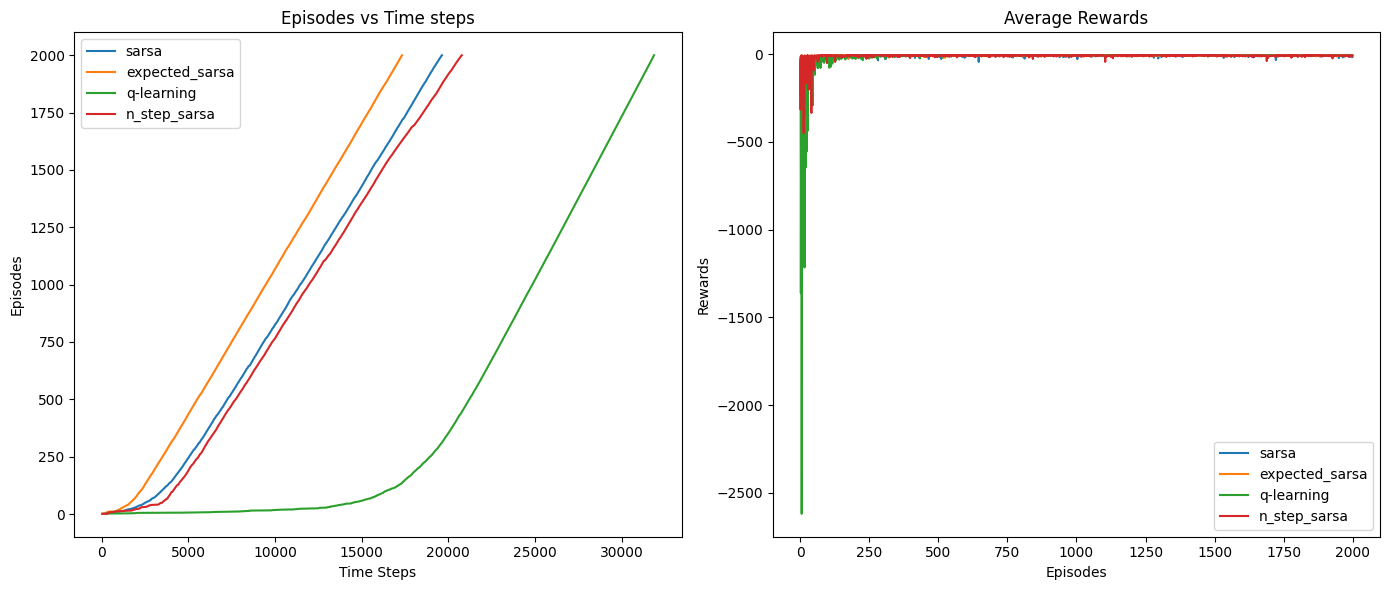

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for method, step_ep_list in step_ep_lists.items():
    axs[0].plot(np.cumsum(step_ep_list), range(1, num_episodes + 1), label=f"{method}")

axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("Episodes")
axs[0].set_title('Episodes vs Time steps', fontsize='large')
axs[0].legend()



# Plotting Episodes vs Time steps
for method, reward in rewards.items():
    axs[1].plot(range(len(reward)), reward, label=f"{method}")

axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Rewards")
axs[1].set_title('Average Rewards', fontsize='large')
axs[1].legend()

plt.tight_layout()
plt.show()

> **Inferences (All Temporal Difference method)**
* According to the graph, Expected SARSA has the best performance in stochastic environment through the observation of the negative rewards.
* Q-learning has the most steps over the episodes.
* SARSA recorded fewer runtime, as it require less computational cost than Expected SARSA
* Surprisingly, based on the graph, we oberved that SARSA performed more stable than Expected SARSA in Stochastc Windy Environment.
* The reason might be the stochasticity in the environment lead to more unpredictable outcome, which lead to higher variance.
* The variance in Expected SARSA arises from the nature of its update rule, which involves an expectation over action probabilities. SARSA, with its conservative approach based on observed outcomes, tends to be more stable in stochastic environments where the outcomes of actions are uncertain and can vary.
* Qlearning requires the most run time as it explores the environment
* All temporal difference methods gave us same best rewards (-6), but Expected SARSA needs fewer episodes to converge.


#### Monte Carlo Tree Search

reward_e -17
reward_e -13
reward_e -14
reward_e -14
reward_e -10
reward_e -11
reward_e -11
reward_e -18
reward_e -7
reward_e -36

Total Runtime for MCTS: 4.877081632614136 second
Rendering Agent Mode


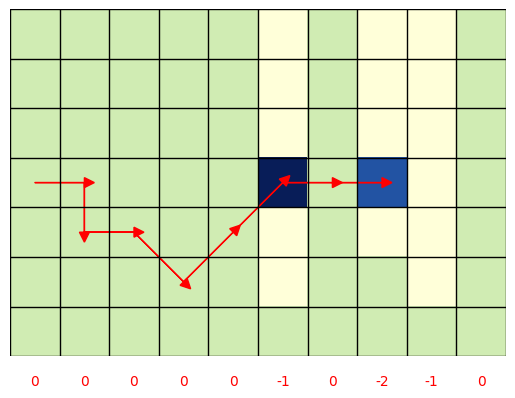

In [158]:
best_reward = -math.inf
episodes = 10
average_values = []
'''
Here we are experimenting with our implementation:
- we play a certain number of episodes of the game
- for deciding each move to play at each step, we will apply our MCTS algorithm
- we will collect and plot the rewards to check if the MCTS is actually working.
'''

for e in range(episodes):
    start = time.time()
    path = [(3,0)]
    reward_e = 0
    game = StochasticWindyGridWorldEnvKingsMove()
    observation = game.reset()
    done = False

    new_game = deepcopy(game)
    mytree = Node(new_game, False, 0, observation, 0)

    while not done:

        mytree, action = Policy_Player_MCTS(mytree)

        observation, reward, done, _ = game.step(action)

        reward_e = reward_e + reward

        if observation not in path:
            path.append(observation)

        if done:
            print('reward_e ' + str(reward_e))
            game.close()
            break

    end = time.time()

    if reward_e > best_reward:
        best_reward = reward_e
        best_path = path
        best_time = end - start


print("\nTotal Runtime for MCTS:", str(best_time), "second")
game.render('without_q_table', False, None, best_path)

**Inference for MCTS**

The MCTS is runned for 10 episodes to get the episode with best rewards. Then, the optimal path walked in that episode is shown. The rewards are much better than the agent in windy grid world environment without stochastic on the wind effect. It needs much time for only about 4.08 seconds to reach the goal state which is much faster than 20 seconds in previous environment.

### Overall Comparison between different Tabular Reinfocement Learning Methods**<br><br>


> **For Windy Grid World Environment**

|Method|Number of Episodes/Iteration to Converge|Best Reward|Time needed (seconds)|
|:-:|:--|:--|:--|
|Policy Iteration|5|-6|1.2407803535461426|
|Value Iteration|132|-6|0.08241057395935059|
|On Policy First Visit Monte Carlo|20000|-6|367.15100502967834|
|SARSA(0)|350|-6|0.16296911239624023|
|Expected SARSA|150|-6|0.48926210403442383|
|Q Learning|200|-6|3.144244432449341|
|N-step SARSA|900|-6|1.558542013168335|
|Monte Carlo Tree Search|-|-28|66.92324018478394|

<br><br>
> **For Stochastic Windy Grid World Environment**

|Method|Number of Episodes/Iteration to Converge|Best Reward|Time needed (seconds)|
|:-:|:--|:--|:--|
|Policy Iteration|4|-6|1.1687695980072021|
|Value Iteration|132|-6|0.28325581550598145|
|On Policy First Visit Monte Carlo|20000|-6|27.552297830581665|
|SARSA(0)|300|-6|0.11304426193237305|
|Expected SARSA|150|-6|0.1438581943511963|
|Q Learning|800|-6|0.6194775104522705|
|N-step SARSA|300|-6|0.8407659530639648|
|Monte Carlo Tree Search|-|-7|4.086458921432495|

<br><br>
> **Inferences**

- Based on the above tables, we can see that Policy Iteration consistently shows fast convergence in both environments.
- Value Iteration is efficient in terms of best reward and convergence speed.
- Policy Evaluation converges in fewer episodes, meaning that the process of updating the state values until they stabilize takes less time in terms of the number of iterations through the state space.
- However, each iteration of Policy Evaluation might involve more computations or updates for each state, potentially making each episode more computationally expensive.
- The differences in the update mechanisms contribute to this trade-off. Policy Evaluation updates values iteratively until convergence, potentially requiring fewer total updates. Value Iteration, on the other hand, performs more aggressive sweeping updates, but each update may be less computationally intensive.
<br><br>
- On Policy First Visit Monte Carlo is slow and computationally expensive,it required the most number of episodes to converge.
- Monte Carlo methods estimate returns by sampling complete episodes. This can lead to high variance in the estimates. High variance in the estimates requires more samples to converge to an accurate value, which then lead to slower convergence.
- On-policy Monte Carlo methods require the agent to complete an entire episode before making any updates to the value function. This can result in slower learning.
<br><br>
- SARSA(0) and Expected SARSA exhibit fast convergence speeds with relatively low time requirements and relativelely less episodes.
- Both SARSA(0) and Expected SARSA are on-policy methods. This means they update their action-value estimates based on the actions actually taken by the current policy. This on-policy characteristic allows them to learn directly from the exploration strategy of the policy, contributing to more consistent and stable updates.
- SARSA(0) and Expected SARSA are TD learning methods, leveraging the temporal difference error for updates. This enables them to learn efficiently from each time step, incorporating immediate rewards and updating estimates incrementally. This can lead to faster convergence compared to methods that rely on full episodes, such as Monte Carlo methods.
-SARSA(0) directly updates its Q-values based on the current policy, ensuring consistency between the learned values and the actions taken by the agent. This policy consistency contributes to stable and reliable learning, especially in scenarios where the environment is changing.
<br><br>
- Q Learning can also converged but it required more time compared to SARSA and Expected SARSA.
- This in line with our hypothesis as Q-learning is an off-policy algorithm.
- In Q-learning, the agent updates its Q-values based on the maximum Q-value of the next state, regardless of the action actually taken. This can lead to more exploration and a potentially slower convergence rate compared to SARSA and Expected SARSA
<br><br>
- Meanwhile N-step SARSA required the most number of episodes to converge among all TD Methods.
- N-step SARSA involves bootstrapping over N time steps, and the variance in these updates can be higher compared to one-step updates. Higher variance may result in slower convergence.
<br><br>
- MCTS needs the second longest time to finish running in both environments because it needs a huge number of iterations to get the optimal path.
- MCTS explore the search space by building a tree of possible moves and outcomes.
- When the search space is large, it takes more time to explore it.
<br><br>
- Overall, for all methods, time needed to converge/run is shorter for Stochastic Windy Grid World environment, compared to Windy Grid World environment. This might due to several possible reasons:
  - The Stochastic Windy Grid World introduces randomness or stochasticity in the transitions between states. This stochastic element can aid exploration by adding uncertainty to the agent's experience. The introduction of stochasticity can make the learning process more efficient, allowing the agent to explore different paths and learn a more robust policy.
  - Stochastic environments often facilitate more effective exploration. The inherent uncertainty encourages the agent to try different actions and paths, potentially discovering better strategies more quickly. In a deterministic environment, the lack of stochasticity might lead to a more cautious exploration strategy, slowing down the learning process.
  - The randomness in the Stochastic Windy Grid World can introduce variability in the agent's experiences. This variability can be beneficial for the learning process, allowing the agent to generalize its knowledge better and converge to a solution more efficiently.

### Conclusion

- According to the overall results, Expected SARSA is the best RL method as it required less episodes to converge and its runtime is faster than all other methods, except SARSA(0).
- Dynamic Programming methods (Policy Iteration and Value Iteration) also have very outstanding performance; however, they have certain limitations that make them less convenient compared to other tabular methods. For example, DP methods require access to the complete model of the environment, including the transition probabilities and rewards for each state-action pair. This is often impractical in real-world applications where the environment is unknown, partially observable, or has a large state space.
- In conclusion, our best methods to solve both of the environments are **SARSA(0)** and **Expected SARSA**.

### Increase Environment Complexity

We have created two extra environment, which will be solved using the best methods (Expected SARSA and SARSA(0)) obtained from above.

**Stochastic Windy Grid World with Obstacles**

The Obstacles Stochastic Windy GridWorld with King's Moves presents an additional layer of complexity by introducing obstacles to the challenging environment. This environment builds upon the Stochastic Windy GridWorld, incorporating obstacles that agents must navigate around to reach the goal state. The dynamics include stochastic wind effects and the possibility of encountering obstacles in specific grid cells.

>Key Features:

* Grid Dimensions: GRID_HEIGHT=7, GRID_WIDTH=10.<br>
* Stochastic Wind: Wind strengths are subject to stochastic effects, introducing uncertainty in the agent's vertical movements, with a probability of 1/3 for up, down, and stay respectively.<br>
* Obstacles: Presence of obstacles that agents must avoid while navigating the grid.<br>
* Start and Goal States: START STATE: (3,0), GOAL STATE: (3,7)<br>
* Visualization: Provides a visual representation of optimal paths using a Q-table.<br>

In [159]:
class ObstaclesStochasticWindyGridWorldEnvKingsMove(gym.Env):
    '''Creates the Stochastic Windy GridWorld Environment with King's moves and obstacles'''
    def __init__(self, GRID_HEIGHT=7, GRID_WIDTH=10, WIND=[0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
                 START_STATE=(3, 0), GOAL_STATE=(3, 7), REWARD=-1, OBSTACLES=[(1, 0), (0, 1), (2, 4), (0, 5), (3, 3), (5, 3), (6, 2), (6, 7), (4, 5)]):
        self.grid_height = GRID_HEIGHT
        self.grid_width = GRID_WIDTH
        self.wind = WIND
        self.start_state = START_STATE
        self.goal_state = GOAL_STATE
        self.reward = REWARD
        self.action_space = gym.spaces.Discrete(8)  # 8 possible moves (King's moves)
        self.observation_space = gym.spaces.Tuple((
            gym.spaces.Discrete(self.grid_height),
            gym.spaces.Discrete(self.grid_width)))
        self.actions = {
            'N': 0, 'NE': 1, 'E': 2, 'SE': 3, 'S': 4, 'SW': 5, 'W': 6, 'NW': 7
        }

        self.obstacles = OBSTACLES  # List of obstacle positions

        # set up destinations for each action in each state
        self.action_destination = np.empty((self.grid_height, self.grid_width), dtype=dict)
        self.stochastic_wind_probability = [1/3, 1/3, 1/3]  # Move 1 cell up, stay, or move 1 cell down with equal probability

        for i in range(0, self.grid_height):
            for j in range(0, self.grid_width):
                destination = dict()
                for action in self.actions.values():
                    wind_strength = self.wind[j]

                    if wind_strength > 0:
                        # Apply stochastic wind effect
                        stochastic_wind_effect = np.random.choice([-1, 0, 1], p=self.stochastic_wind_probability)
                        wind_strength *= stochastic_wind_effect

                    if action == self.actions['N']:
                        destination[action] = (max(i - 1 - wind_strength, 0), j)
                    elif action == self.actions['NE']:
                        destination[action] = (max(i - 1 - wind_strength, 0), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['E']:
                        destination[action] = (max(i - wind_strength, 0), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['SE']:
                        destination[action] = (max(min(i + 1 - wind_strength, self.grid_height - 1),0), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['S']:
                        destination[action] = (max(min(i + 1 - wind_strength, self.grid_height - 1),0), j)
                    elif action == self.actions['SW']:
                        destination[action] = (max(min(i + 1 - wind_strength, self.grid_height - 1),0), max(j - 1, 0))
                    elif action == self.actions['W']:
                        destination[action] = (max(i - wind_strength, 0), max(j - 1, 0))
                    elif action == self.actions['NW']:
                        destination[action] = (max(i - 1 - wind_strength, 0), max(j - 1, 0))
                self.action_destination[i, j] = destination
        self.nA = len(self.actions)

    def step(self, action):
        """
        Parameters
        ----------
        action: 0 = N, 1 = NE, 2 = E, 3 = SE, 4 = S, 5 = SW, 6 = W, 7 = NW

        Returns
        -------
        ob (object):
             Agent current position in the grid.
        reward (float):
             Reward is -1 at every step.
        episode_over (bool):
             True if the agent reaches the goal, False otherwise.
        info (dict):
             Contains no additional information.
        """
        assert self.action_space.contains(action)
        next_state = self.action_destination[self.observation[0], self.observation[1]][action]

        # Ensure the new position stays within the grid boundaries
        next_state = (
            max(0, min(next_state[0], self.grid_height - 1)),
            max(0, min(next_state[1], self.grid_width - 1))
        )

        # Check for obstacles
        if next_state in self.obstacles:
            # If the next state is an obstacle, stay in the current state
            next_state = self.observation
        else:
            self.observation = next_state

        if self.observation == self.goal_state:
            return self.observation, -1, True, {}
        return self.observation, -1, False, {}

    def reset(self):
        ''' Resets the agent position back to the starting position'''
        self.observation = self.start_state
        return self.observation

    def visualize_best_path(self, q_table):
        grid = np.zeros((self.grid_height, self.grid_width))
        current_state = self.reset()
        path = [current_state]
        reward = 0

        while True:
            action = np.argmax(q_table[current_state])
            next_state, current_reward, done, _ = self.step(action)
            path.append(next_state)
            current_state = next_state
            reward += current_reward

            if done:
                break

        for state in path:
            grid[state[0], state[1]] = 0.9  # Highlight the path
        grid[self.start_state[0], self.start_state[1]] = 0.5
        grid[self.goal_state[0], self.goal_state[1]] = 0.7

        # Display obstacles
        for obstacle in self.obstacles:
            grid[obstacle[0], obstacle[1]] = 0.3  # Obstacle color

        # Label wind strength for each column
        for j, w in enumerate(self.wind):
            plt.text(j, self.grid_height, str(w), color='black', ha='center', va='center')

        plt.imshow(grid, cmap='YlGnBu')

        for i in range(self.grid_height + 1):
            plt.axhline(y=i - 0.5, color='black', linewidth=1)  # Horizontal gridlines
        for j in range(self.grid_width + 1):
            plt.axvline(x=j - 0.5, color='black', linewidth=1)  # Vertical gridlines

        for i in range(len(path) - 1):
            plt.arrow(path[i][1], path[i][0], path[i + 1][1] - path[i][1], path[i + 1][0] - path[i][0],
                      color='red', head_width=0.2, head_length=0.2)

        plt.axis('off')
        plt.show()

        print("Total Reward:", reward)

    def render(self, mode='human', close=False, q_table=None):
        if mode == 'human':
            print("Rendering Human Mode")
            # Add any human-specific rendering code here
        elif mode == 'agent':
            print("Rendering Agent Mode")
            if q_table is not None:
                self.visualize_best_path(q_table)
            else:
                print("Please provide a Q-table for rendering.")
        else:
            super().render(mode=mode)  # Use the default rendering for other modes

    def seed(self, seed=None):
        pass

In [160]:
# Define parameters
num_episodes = 2000
alpha = 0.5
epsilon = 0.1
gamma = 0.9

env = ObstaclesStochasticWindyGridWorldEnvKingsMove()
sarsa_q_table, sarsa_episode_rewards, sarsa_episode_steps = sarsa(env, num_episodes, alpha, gamma, epsilon)

Rendering Agent Mode


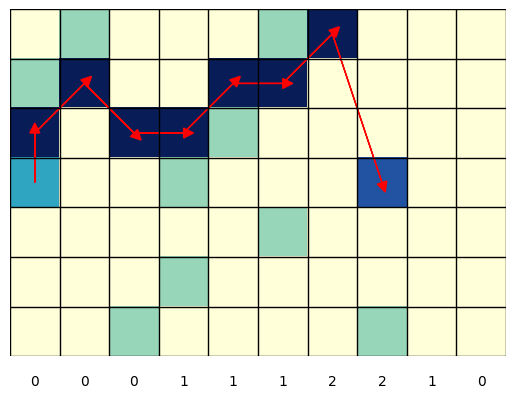

Total Reward: -8


In [161]:
env.render(mode='agent', q_table=sarsa_q_table)

In [162]:
# Define parameters
num_episodes = 2000
alpha = 1.0
epsilon = 0.1
gamma = 1

env = ObstaclesStochasticWindyGridWorldEnvKingsMove()
expected_sarsa_q_table, expected_sarsa_episode_rewards, expected_sarsa_episode_steps = expected_sarsa(env, num_episodes, alpha, gamma, epsilon)

Rendering Agent Mode


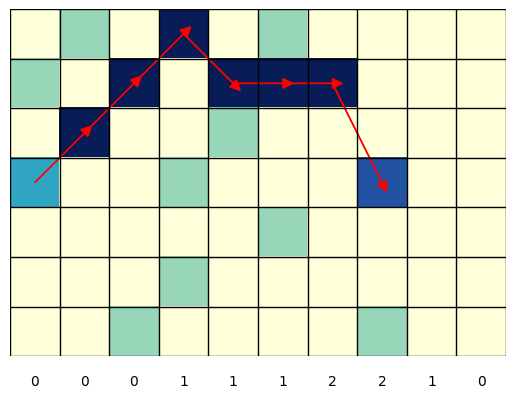

Total Reward: -7


In [163]:
env.render(mode='agent', q_table=expected_sarsa_q_table)

<br>**Stochastic Windy Grid World with Stochastic Obstacles**

The Stochastic Obstacles Windy GridWorld with King's Moves further increases the challenge by introducing stochastic obstacles. This environment combines the uncertainty of wind effects, the presence of obstacles, and the additional element of stochasticity in obstacle occurrence. Agents must navigate through the grid, considering both wind dynamics and the unpredictable appearance of obstacles.

>Key Features:

* Grid Dimensions: GRID_HEIGHT=7, GRID_WIDTH=10.<br>
* Stochastic Wind: Wind strengths are subject to stochastic effects, introducing uncertainty in the agent's vertical movements, with a probability of 1/3 for up, down, and stay respectively.<br>
* Stochastic Obstacles: Obstacles can appear randomly in each cell with a specified probability (0.1).<br>
* Start and Goal States: START STATE: (3,0), GOAL STATE: (3,7)<br>
* Visualization: Provides a visual representation of optimal paths using a Q-table.<br>

In [164]:
class StochasticObstaclesWindyGridWorldEnvKingsMove(gym.Env):
    '''Creates the Stochastic Windy GridWorld Environment with King's moves and stochastic obstacles'''
    def __init__(self, GRID_HEIGHT=7, GRID_WIDTH=10, WIND=[0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
                 START_STATE=(3, 0), GOAL_STATE=(3, 7), REWARD=-1, OBSTACLE_PROBABILITY=0.1):
        self.grid_height = GRID_HEIGHT
        self.grid_width = GRID_WIDTH
        self.wind = WIND
        self.start_state = START_STATE
        self.goal_state = GOAL_STATE
        self.reward = REWARD
        self.action_space = spaces.Discrete(8)  # 8 possible moves (King's moves)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_height),
            spaces.Discrete(self.grid_width)))
        self.actions = {
            'N': 0, 'NE': 1, 'E': 2, 'SE': 3, 'S': 4, 'SW': 5, 'W': 6, 'NW': 7
        }

        self.obstacle_probability = OBSTACLE_PROBABILITY  # Probability of an obstacle in each cell

        # set up destinations for each action in each state
        self.action_destination = np.empty((self.grid_height, self.grid_width), dtype=dict)
        self.stochastic_wind_probability = [1/3, 1/3, 1/3]  # Move 1 cell up, stay, or move 1 cell down with equal probability

        self.obstacles = self.generate_stochastic_obstacles()

        for i in range(0, self.grid_height):
            for j in range(0, self.grid_width):
                destination = dict()
                for action in self.actions.values():
                    wind_strength = self.wind[j]

                    if wind_strength > 0:
                        # Apply stochastic wind effect
                        stochastic_wind_effect = np.random.choice([-1, 0, 1], p=self.stochastic_wind_probability)
                        wind_strength *= stochastic_wind_effect

                    if action == self.actions['N']:
                        destination[action] = (max(i - 1 - wind_strength, 0), j)
                    elif action == self.actions['NE']:
                        destination[action] = (max(i - 1 - wind_strength, 0), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['E']:
                        destination[action] = (max(i - wind_strength, 0), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['SE']:
                        destination[action] = (max(min(i + 1 - wind_strength, self.grid_height - 1),0), min(j + 1, self.grid_width - 1))
                    elif action == self.actions['S']:
                        destination[action] = (max(min(i + 1 - wind_strength, self.grid_height - 1),0), j)
                    elif action == self.actions['SW']:
                        destination[action] = (max(min(i + 1 - wind_strength, self.grid_height - 1),0), max(j - 1, 0))
                    elif action == self.actions['W']:
                        destination[action] = (max(i - wind_strength, 0), max(j - 1, 0))
                    elif action == self.actions['NW']:
                        destination[action] = (max(i - 1 - wind_strength, 0), max(j - 1, 0))
                self.action_destination[i, j] = destination
        self.nA = len(self.actions)

    def generate_stochastic_obstacles(self):
        """Generate stochastic obstacles based on the specified probability."""
        obstacles = []
        for i in range(self.grid_height):
            for j in range(self.grid_width):
                if (i, j) != self.start_state and (i, j) != self.goal_state and np.random.rand() < self.obstacle_probability:
                    obstacles.append((i, j))
        return obstacles

    def step(self, action):
        assert self.action_space.contains(action)
        next_state = self.action_destination[self.observation[0], self.observation[1]][action]

        # Ensure the new position stays within the grid boundaries
        next_state = (
            max(0, min(next_state[0], self.grid_height - 1)),
            max(0, min(next_state[1], self.grid_width - 1))
        )

        # Check for obstacles
        if next_state in self.obstacles:
            # If the next state is an obstacle, stay in the current state
            next_state = self.observation
        else:
            self.observation = next_state

        if self.observation == self.goal_state:
            return self.observation, -1, True, {}
        return self.observation, -1, False, {}

    def reset(self):
        ''' Resets the agent position back to the starting position'''
        self.observation = self.start_state
        return self.observation

    def visualize_best_path(self, q_table):
        grid = np.zeros((self.grid_height, self.grid_width))
        current_state = self.reset()
        path = [current_state]
        reward = 0

        while True:
            action = np.argmax(q_table[current_state])
            next_state, current_reward, done, _ = self.step(action)
            path.append(next_state)
            current_state = next_state
            reward += current_reward

            if done:
                break

        for state in path:
            grid[state[0], state[1]] = 0.9  # Highlight the path
        grid[self.start_state[0], self.start_state[1]] = 0.5
        grid[self.goal_state[0], self.goal_state[1]] = 0.7

        # Display obstacles
        for obstacle in self.obstacles:
            grid[obstacle[0], obstacle[1]] = 0.3  # Obstacle color

        # Label wind strength for each column
        for j, w in enumerate(self.wind):
            plt.text(j, self.grid_height, str(w), color='black', ha='center', va='center')

        plt.imshow(grid, cmap='YlGnBu')

        for i in range(self.grid_height + 1):
            plt.axhline(y=i - 0.5, color='black', linewidth=1)  # Horizontal gridlines
        for j in range(self.grid_width + 1):
            plt.axvline(x=j - 0.5, color='black', linewidth=1)  # Vertical gridlines

        for i in range(len(path) - 1):
            plt.arrow(path[i][1], path[i][0], path[i + 1][1] - path[i][1], path[i + 1][0] - path[i][0],
                      color='red', head_width=0.2, head_length=0.2)

        plt.axis('off')
        plt.show()

        print("Total Reward:", reward)

    def render(self, mode='human', close=False, q_table=None):
        if mode == 'human':
            print("Rendering Human Mode")
            # Add any human-specific rendering code here
        elif mode == 'agent':
            print("Rendering Agent Mode")
            if q_table is not None:
                self.visualize_best_path(q_table)
            else:
                print("Please provide a Q-table for rendering.")
        else:
            super().render(mode=mode)  # Use the default rendering for other modes

    def seed(self, seed=None):
        pass

In [165]:
# Define parameters
num_episodes = 2000
alpha = 0.5
epsilon = 0.1
gamma = 0.9

env = StochasticObstaclesWindyGridWorldEnvKingsMove()
sarsa_q_table, sarsa_episode_rewards, sarsa_episode_steps = sarsa(env, num_episodes, alpha, gamma, epsilon)

Rendering Agent Mode


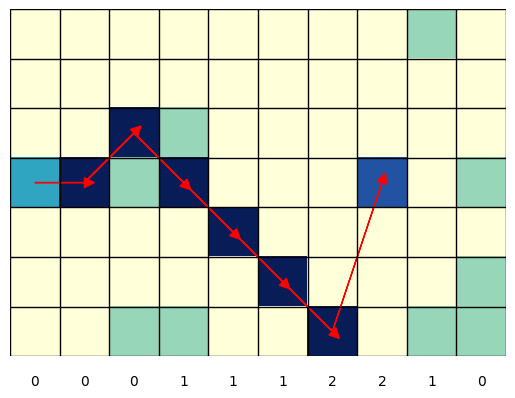

Total Reward: -7


In [166]:
env.render(mode='agent', q_table=sarsa_q_table)

In [167]:
# Define parameters
num_episodes = 2000
alpha = 1.0
epsilon = 0.1
gamma = 1

env = StochasticObstaclesWindyGridWorldEnvKingsMove()
expected_sarsa_q_table, expected_sarsa_episode_rewards, expected_sarsa_episode_steps = expected_sarsa(env, num_episodes, alpha, gamma, epsilon)

Rendering Agent Mode


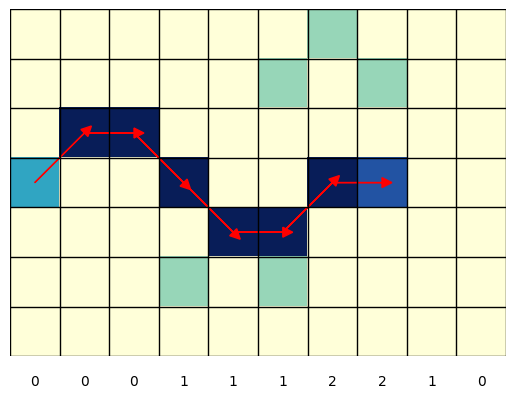

Total Reward: -7


In [168]:
env.render(mode='agent', q_table=expected_sarsa_q_table)

### Discussion

**Integration of Deep Reinforcement Learning**

n tabular reinforcement learning, the state-action pairs are explicitly represented in a table. However, in real-world applications where the state space is large or continuous, tabular methods become impractical due to the huge volume of possible states. Deep reinforcement learning addresses this limitation by leveraging neural networks to approximate the value function or policy.

**Below is key components of DRL for Windy Grid World:**

1. State Representation:

- Encode the state of the Windy Grid World as an input to a neural network. For example, each cell's information, including wind strength, agent position, and potential obstacles, could be represented as features.

2. Action Representation:

- A neural network can handle complex space cause by large environment and king's move, by having multiple output nodes, each corresponding to a possible action, including diagonal movements.

3. Reward Function:

- Define a reward function that encourages the agent to reach the goal efficiently while penalizing inefficient paths. Design the reward structure to guide the agent through the windy conditions effectively.

4. Experience Replay:

- Implement experience replay to store and randomly sample past experiences. This helps in breaking temporal correlations and stabilizing learning.

5. Neural Network:

- Neural Network such as Dueling Deep Q Networks (Dueling DQN) separates the value function and advantage function, allowing for more effective learning in environments with multiple potential actions.

6. Exploration Strategies:

- Implement exploration strategies, such as epsilon-greedy policies or more advanced methods like noisy networks, to ensure the agent explores the windy environment adequately.